In [1]:
from sparkocr import start
import os
import json
import time
import shutil

license = "/content/spark_nlp_for_healthcare_spark_ocr_10057.json"

if license and "json" in license:

    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]
else:
    raise Exception("License JSON File is not specified")

extra_configurations = {
    "spark.extraListeners": "com.johnsnowlabs.license.LicenseLifeCycleManager", #required
    "spark.sql.legacy.allowUntypedScalaUDF" : "true", #required
    "spark.executor.instances" : "7",
    "spark.executor.cores" : "16",
    "spark.executor.memory" : "130G",
    "spark.driver.memory" : "100G",
    "spark.sql.shuffle.partitions" : "896"
}

spark = start(secret=os.environ.get("SPARK_OCR_SECRET"),
              nlp_secret=os.environ.get("SECRET"),
              nlp_internal=os.environ.get("JSL_VERSION"),
              apple_silicon=False,
              nlp_version=os.environ.get("PUBLIC_VERSION"),
              logLevel="INFO",
              extra_conf=extra_configurations)


spark

Spark version: 3.5.0
Spark NLP version: 6.1.1
Spark NLP for Healthcare version: 6.1.0
Spark OCR version: 6.1.0



In [2]:
def write_pdf_to_disk(df, SAVE_OUTPUT_PDF):
  """
  df -> Result Dataframe from deid task.
  SAVE_OUTPUT_PDF -> Path to save output pdf.
  """

  import os

  os.makedirs(SAVE_OUTPUT_PDF, exist_ok=True)

  for row in df.select("path", "pdf").toLocalIterator():
    filename = row.asDict()["path"]
    basename = os.path.basename(filename).replace(".pdf", "")

    result_name = basename + "_result.pdf"

    savename = os.path.join(SAVE_OUTPUT_PDF, result_name)
    print(f"Saving File -> {savename}")

    pdfFile = open(savename, "wb")
    pdfFile.write(row.asDict()["pdf"])
    pdfFile.close()

In [3]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from pyspark.ml import PipelineModel, Pipeline
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

In [4]:
from Utility import AnonymizationPipelineBuilder

# 🏥 AnonymizationPipelineBuilder

The `AnonymizationPipelineBuilder` class helps construct **Spark OCR + Spark NLP Healthcare** pipelines for **deidentification** or **obfuscation** of medical documents. It automates the process of creating an **end-to-end workflow** that can handle **PDFs** or **Images**, extract text via OCR, apply pretrained Healthcare NLP models, and generate **redacted/obfuscated outputs**.

---

## 🔹 Pipeline Structure
- **Pre-NLP Stages**: Convert PDFs/Images, run OCR.  
- **Healthcare NLP Stage**: Apply pretrained Healthcare pipelines.  
- **Post-NLP Stages**: Deidentification/Obfuscation, PositionFinder, visualization, PDF/image reconstruction.  

---

## 🔹 Inputs (with Defaults)
- `hc_pipeline (str)` → **Required**: Name of the pretrained Healthcare NLP pipeline.  
- `language (str)` → Default: `"en"`  
- `remote_loc (str)` → Default: `"clinical/models"`  
- `task (str)` → **Required**: `"deid"` (deidentification) or `"obfuscate"`  
- `input_type (str)` → **Required**: `"pdf"` or `"image"`  
- `ocr (str)` → Default: `"v1"` (supported: `"v1"`, `"v2"`, `"v3"`)  
- `use_gpu (bool)` → Default: `False`  
- `keep_memory (bool)` → Default: `False`  
- `default_matcher_threshold (float)` → Default: `0.7`  
- `matcher_dict (dict)` → Default: `{}`  
- `pdf_finalizer (bool)` → Default: `True`  

---

## 🔹 Outputs
- **Input Formats:** PDF, Image  
- **Output Formats:** PDF, Image, or DataFrame  
- ⚠️ If `pdf_finalizer=False`, the final `ImageToPDF` stage is skipped.  

---

## 🔹 Configuration
Each stage can be tuned via the `individual_stage_settings` dictionary:  

```python
individual_stage_settings = {
    "pdfToImage": {"resolution": 300, "splitBatchNum": 10, "imageType": ImageType.TYPE_BYTE_GRAY,
                   "splittingStrategy": SplittingStrategy.FIXED_NUMBER_OF_PARTITIONS},

    "binaryToImage": {"imageType": ImageType.TYPE_BYTE_GRAY},

    "imageToText": {"ignoreResolution": False, "pageIteratorLevel": PageIteratorLevel.SYMBOL,
                    "pageSegMode": PageSegmentationMode.SPARSE_TEXT, "withSpaces": False,
                    "keepLayout": False, "threshold": 70},

    "imageTextDetectorCraft": {"checkpoint": "image_text_detector_mem_opt", "scoreThreshold": 0.7,
                               "linkThreshold": 0.5, "textThreshold": 0.4, "sizeThreshold": -1,
                               "width": 0, "height": 0, "refiner": True},

    "imageToTextV2": {"checkpoint": "ocr_base_printed_v2_opt", "groupImages": False,
                      "batchSize": 4, "taskParallelism": 8},

    "deidentification": {"keepMonth": True, "keepYear": True, "obfuscateDate": True,
                         "sameEntityThreshold": 0.7, "keepTextSizeForObfuscation": True,
                         "fakerLengthOffset": 2, "returnEntityMappings": True,
                         "days": 2, "ignoreRegex": False, "region": "us", "seed": 40,
                         "consistentObfuscation": True},

    "positionFinder": {"smoothCoordinates": True},
    
    "imageDrawRegions": {"rectColor": Color.black, "fontStyle": FontStyle.PLAIN,
                         "fontName": "SansSerif", "patchTextColor": Color.black,
                         "patchBackgroundColor": Color.white,
                         "redactionList": [], "blackList": [], "dynamicColor": True}
}

In [5]:
help(AnonymizationPipelineBuilder)

Help on class AnonymizationPipelineBuilder in module Utility:

class AnonymizationPipelineBuilder(builtins.object)
 |  AnonymizationPipelineBuilder(hc_pipeline='', language='en', remote_loc='clinical/models', task='deid', input_type='pdf', **kwargs)
 |
 |  Builder class for constructing Spark OCR + Spark NLP Healthcare
 |  deidentification or obfuscation pipelines.
 |
 |  This class automates the process of creating an end-to-end pipeline for
 |  processing PDF or image inputs, extracting text via OCR, applying clinical
 |  deidentification models, and generating redacted/obfuscated outputs.
 |
 |  The pipeline consists of:
 |      - Pre-NLP stages (OCR and text preparation)
 |      - Pretrained Healthcare NLP pipeline
 |      - Post-NLP stages (deidentification, coordinate finding, visualization, PDF/image reconstruction)
 |
 |  Inputs:
 |      hc_pipeline (str): Name of the pretrained Healthcare NLP pipeline.
 |      language (str): Language of the pretrained pipeline (default: "en")

## 📄 Input Types  

- **PDF**  
- **Image**  

---

## 🔧 PDF Variations  

- **`pdf_finalizer = True`**  
  - Adds the **ImageToPDF** stage to the pipeline.  
  - This is an **aggregation stage**.  
  - **Destroys all intermediate results** in the DataFrame.  
  - Keeps **only the final assembled PDF** in the DataFrame.  

- **`pdf_finalizer = False`**  
  - **Skips** adding the ImageToPDF stage.  
  - **Keeps intermediate results** intact in the DataFrame.  
  - Final results are in the form of **Images** instead of a PDF.  

---

## 🎯 Task Types  

- **`deid`** → *Deidentification*  
- **`obfuscate`** → *Obfuscation*  
  - In case of **obfuscation**, `keep_memory` should be **enabled**.  

In [ ]:
input_df = spark.read.format("binaryFile").load("./source_pdfs/Easy/PDF_Deid_Deidentification_0.pdf")

In [6]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="deid",
       ocr="v1",
       use_gpu=False,
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [10]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)
result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']


    Image #0:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


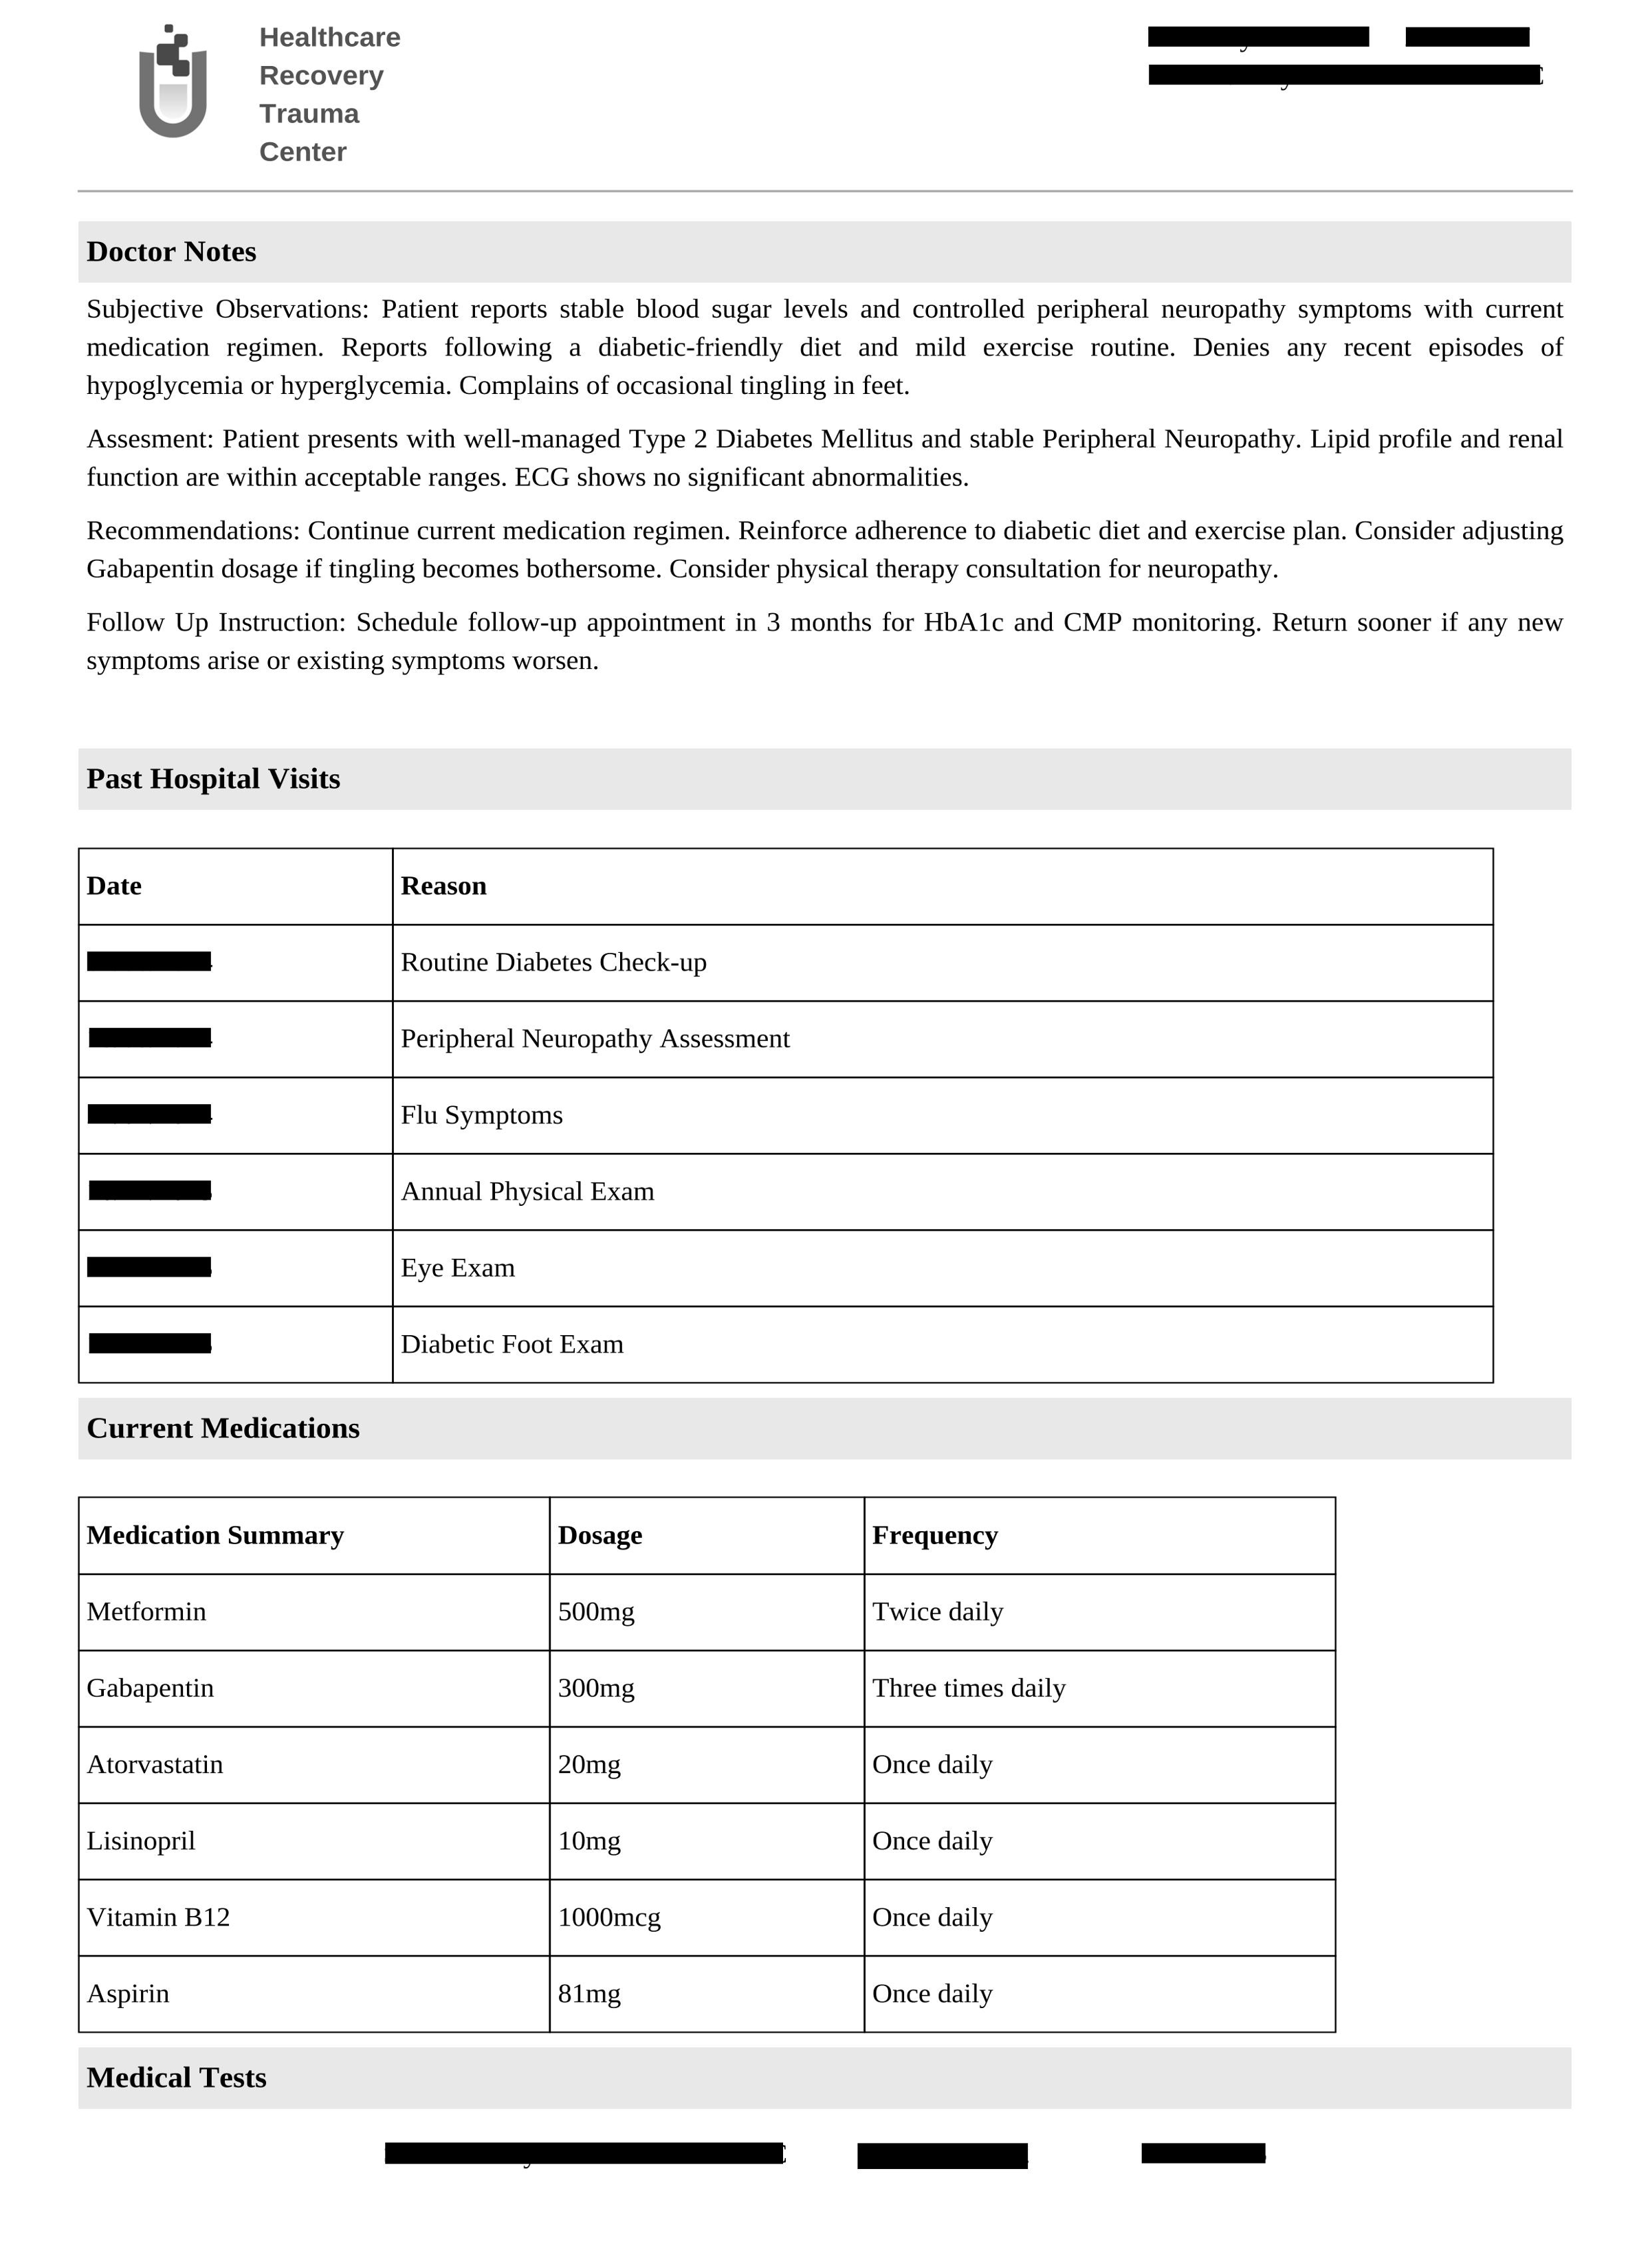


    Image #1:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


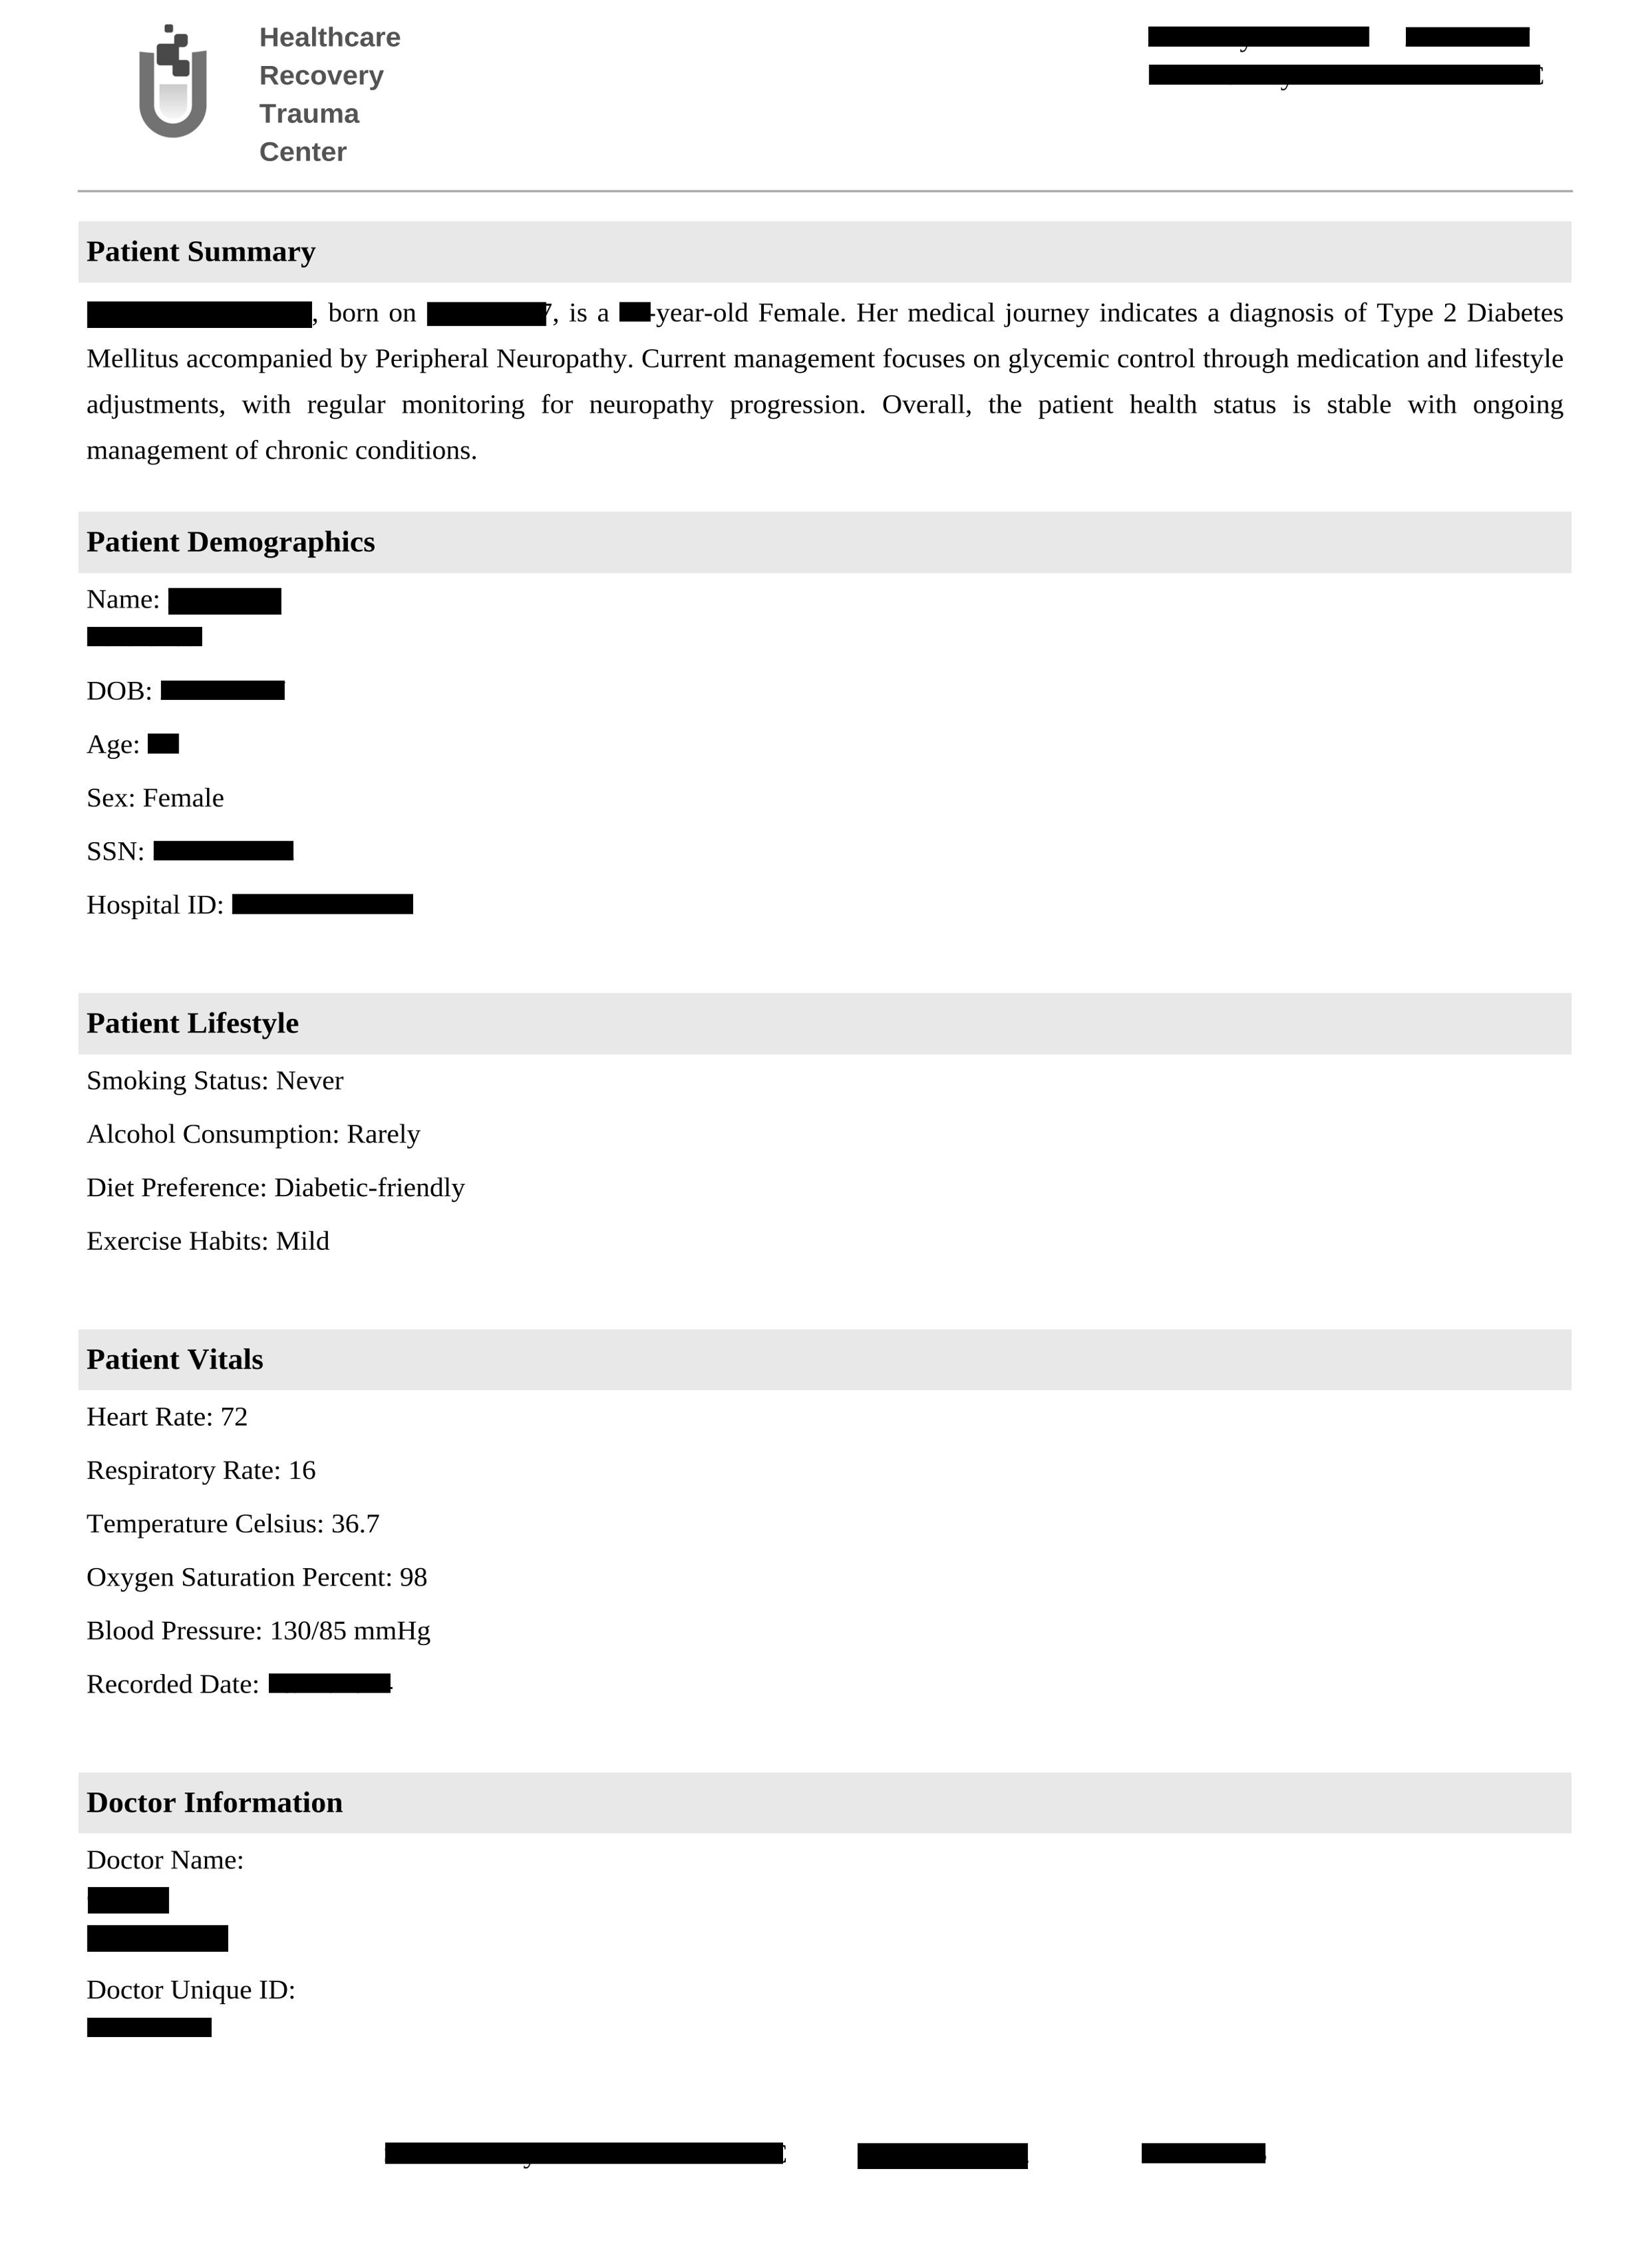


    Image #2:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


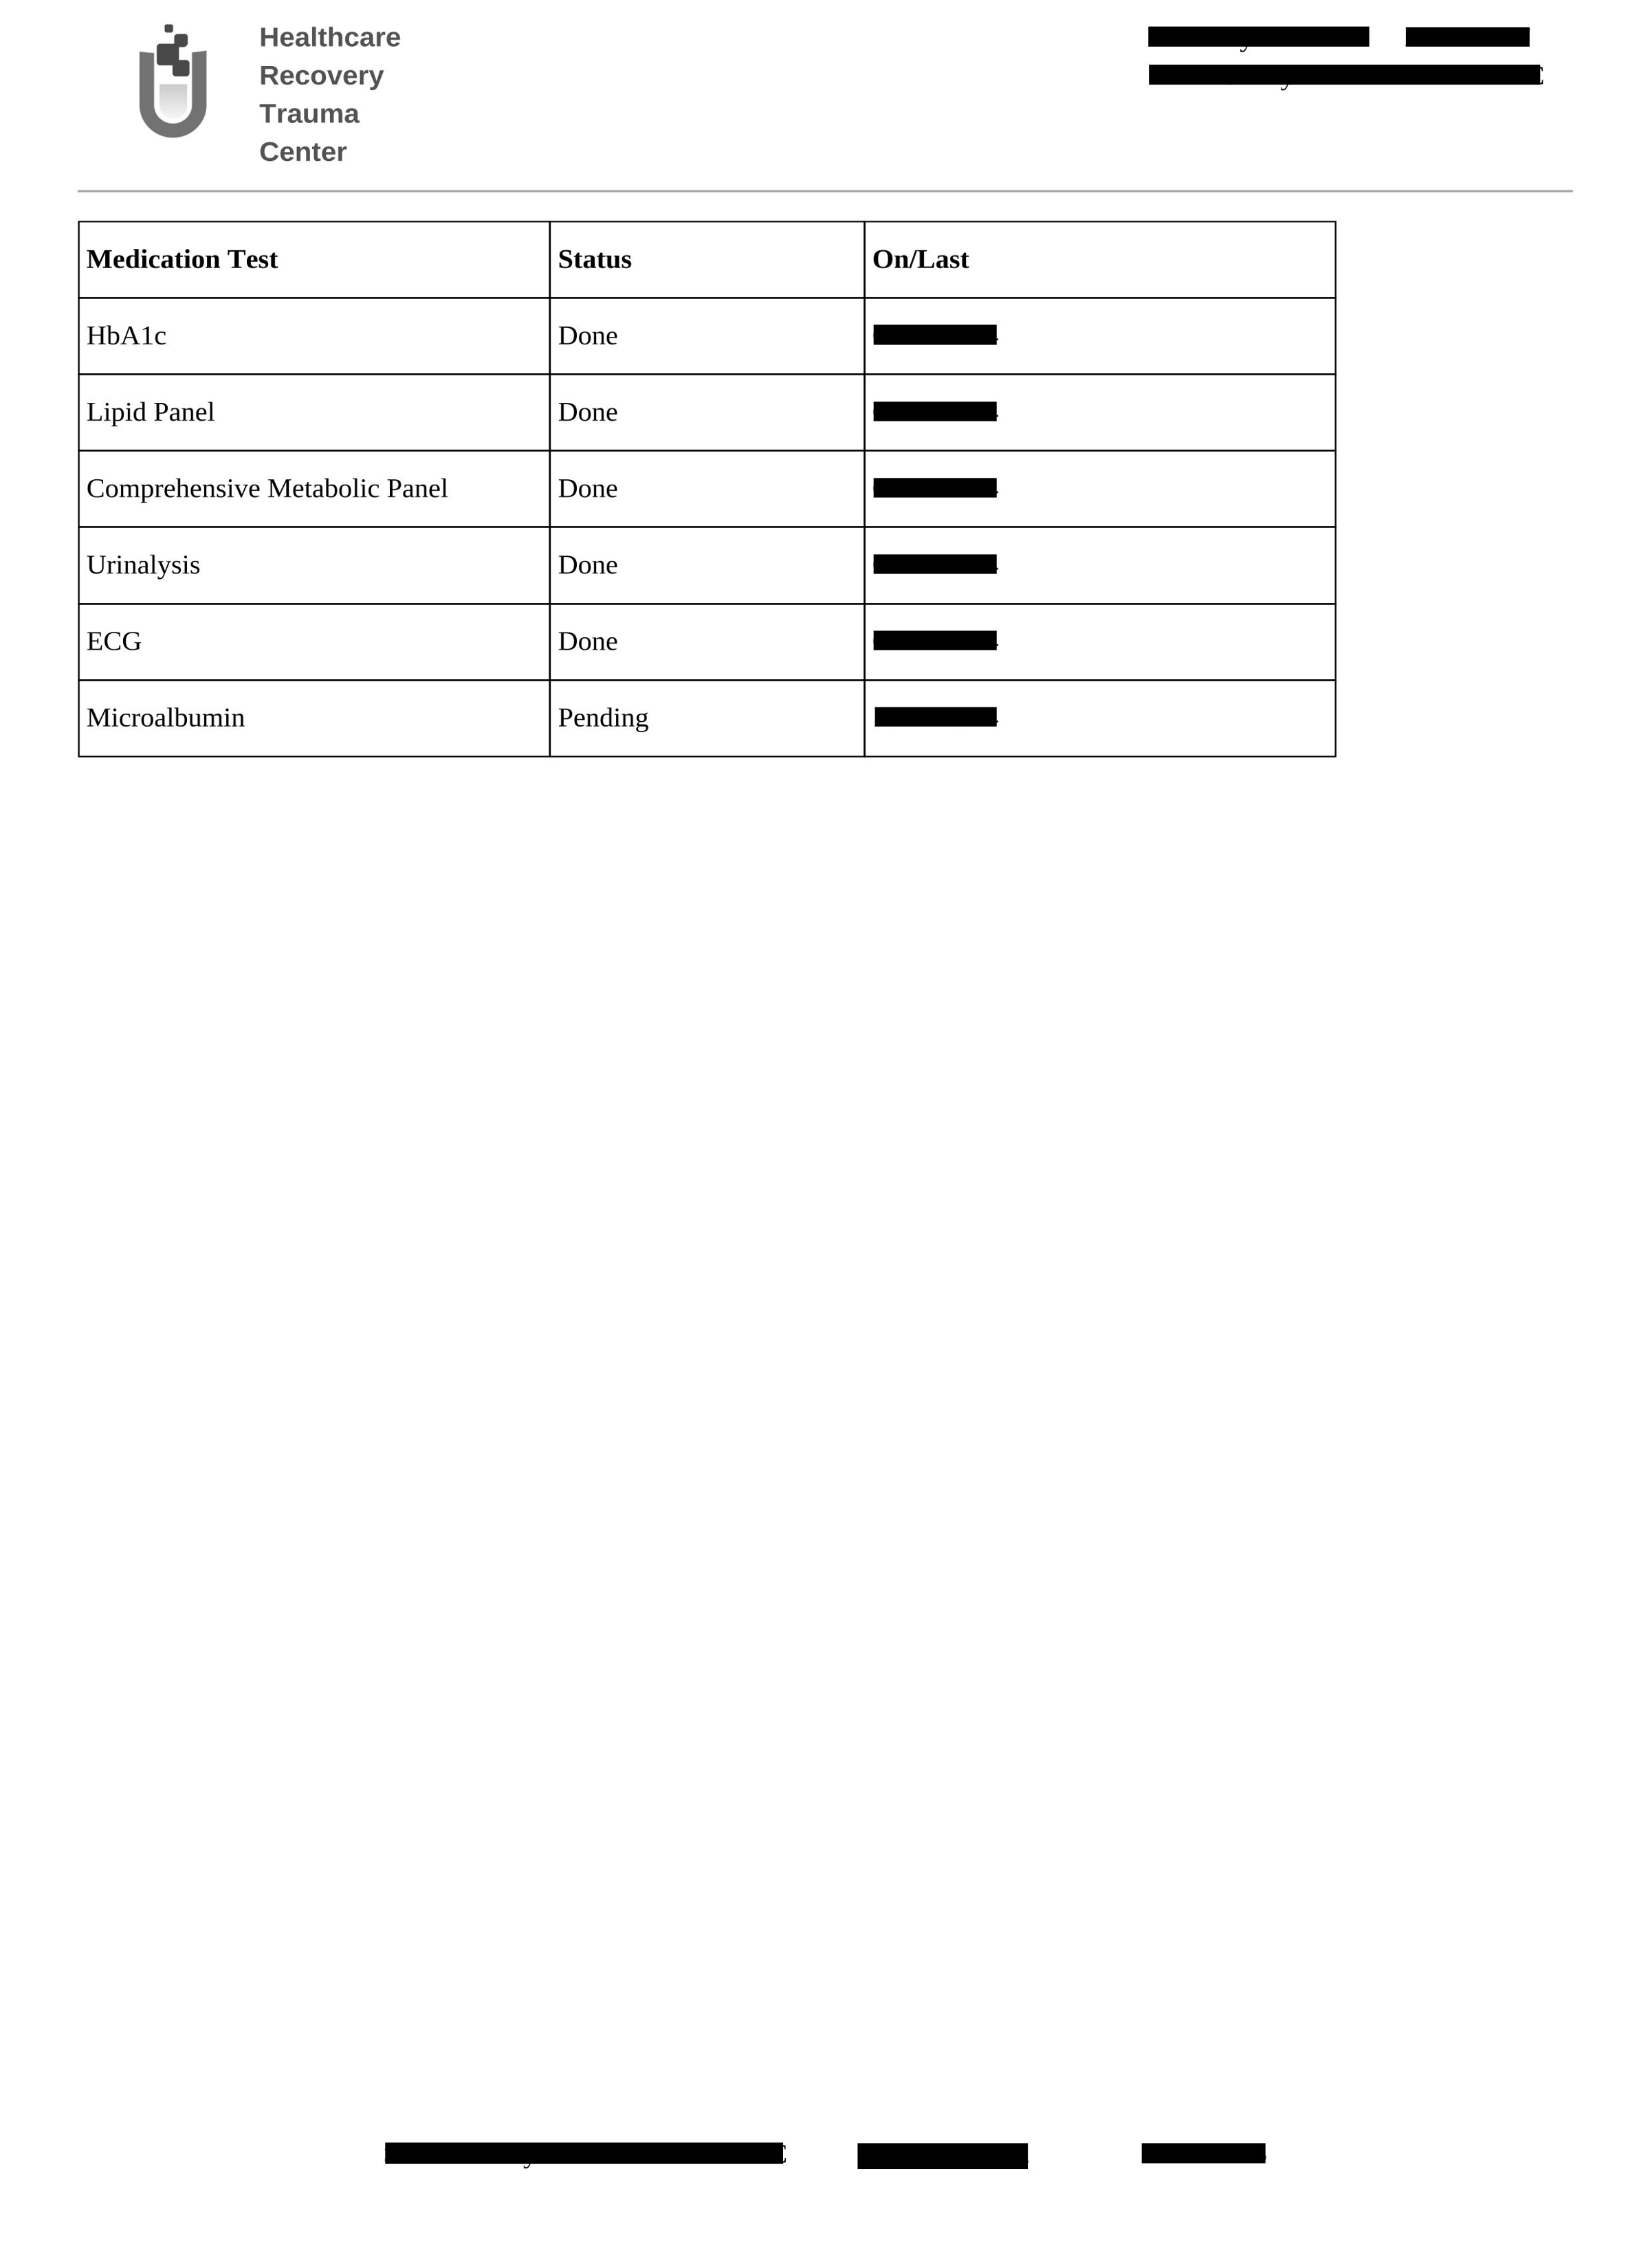

In [11]:
display_pdf(result_df, "pdf")

In [15]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="obfuscate",
       ocr="v1",
       use_gpu=False,
       keep_memory=True
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [16]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']


    Image #0:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


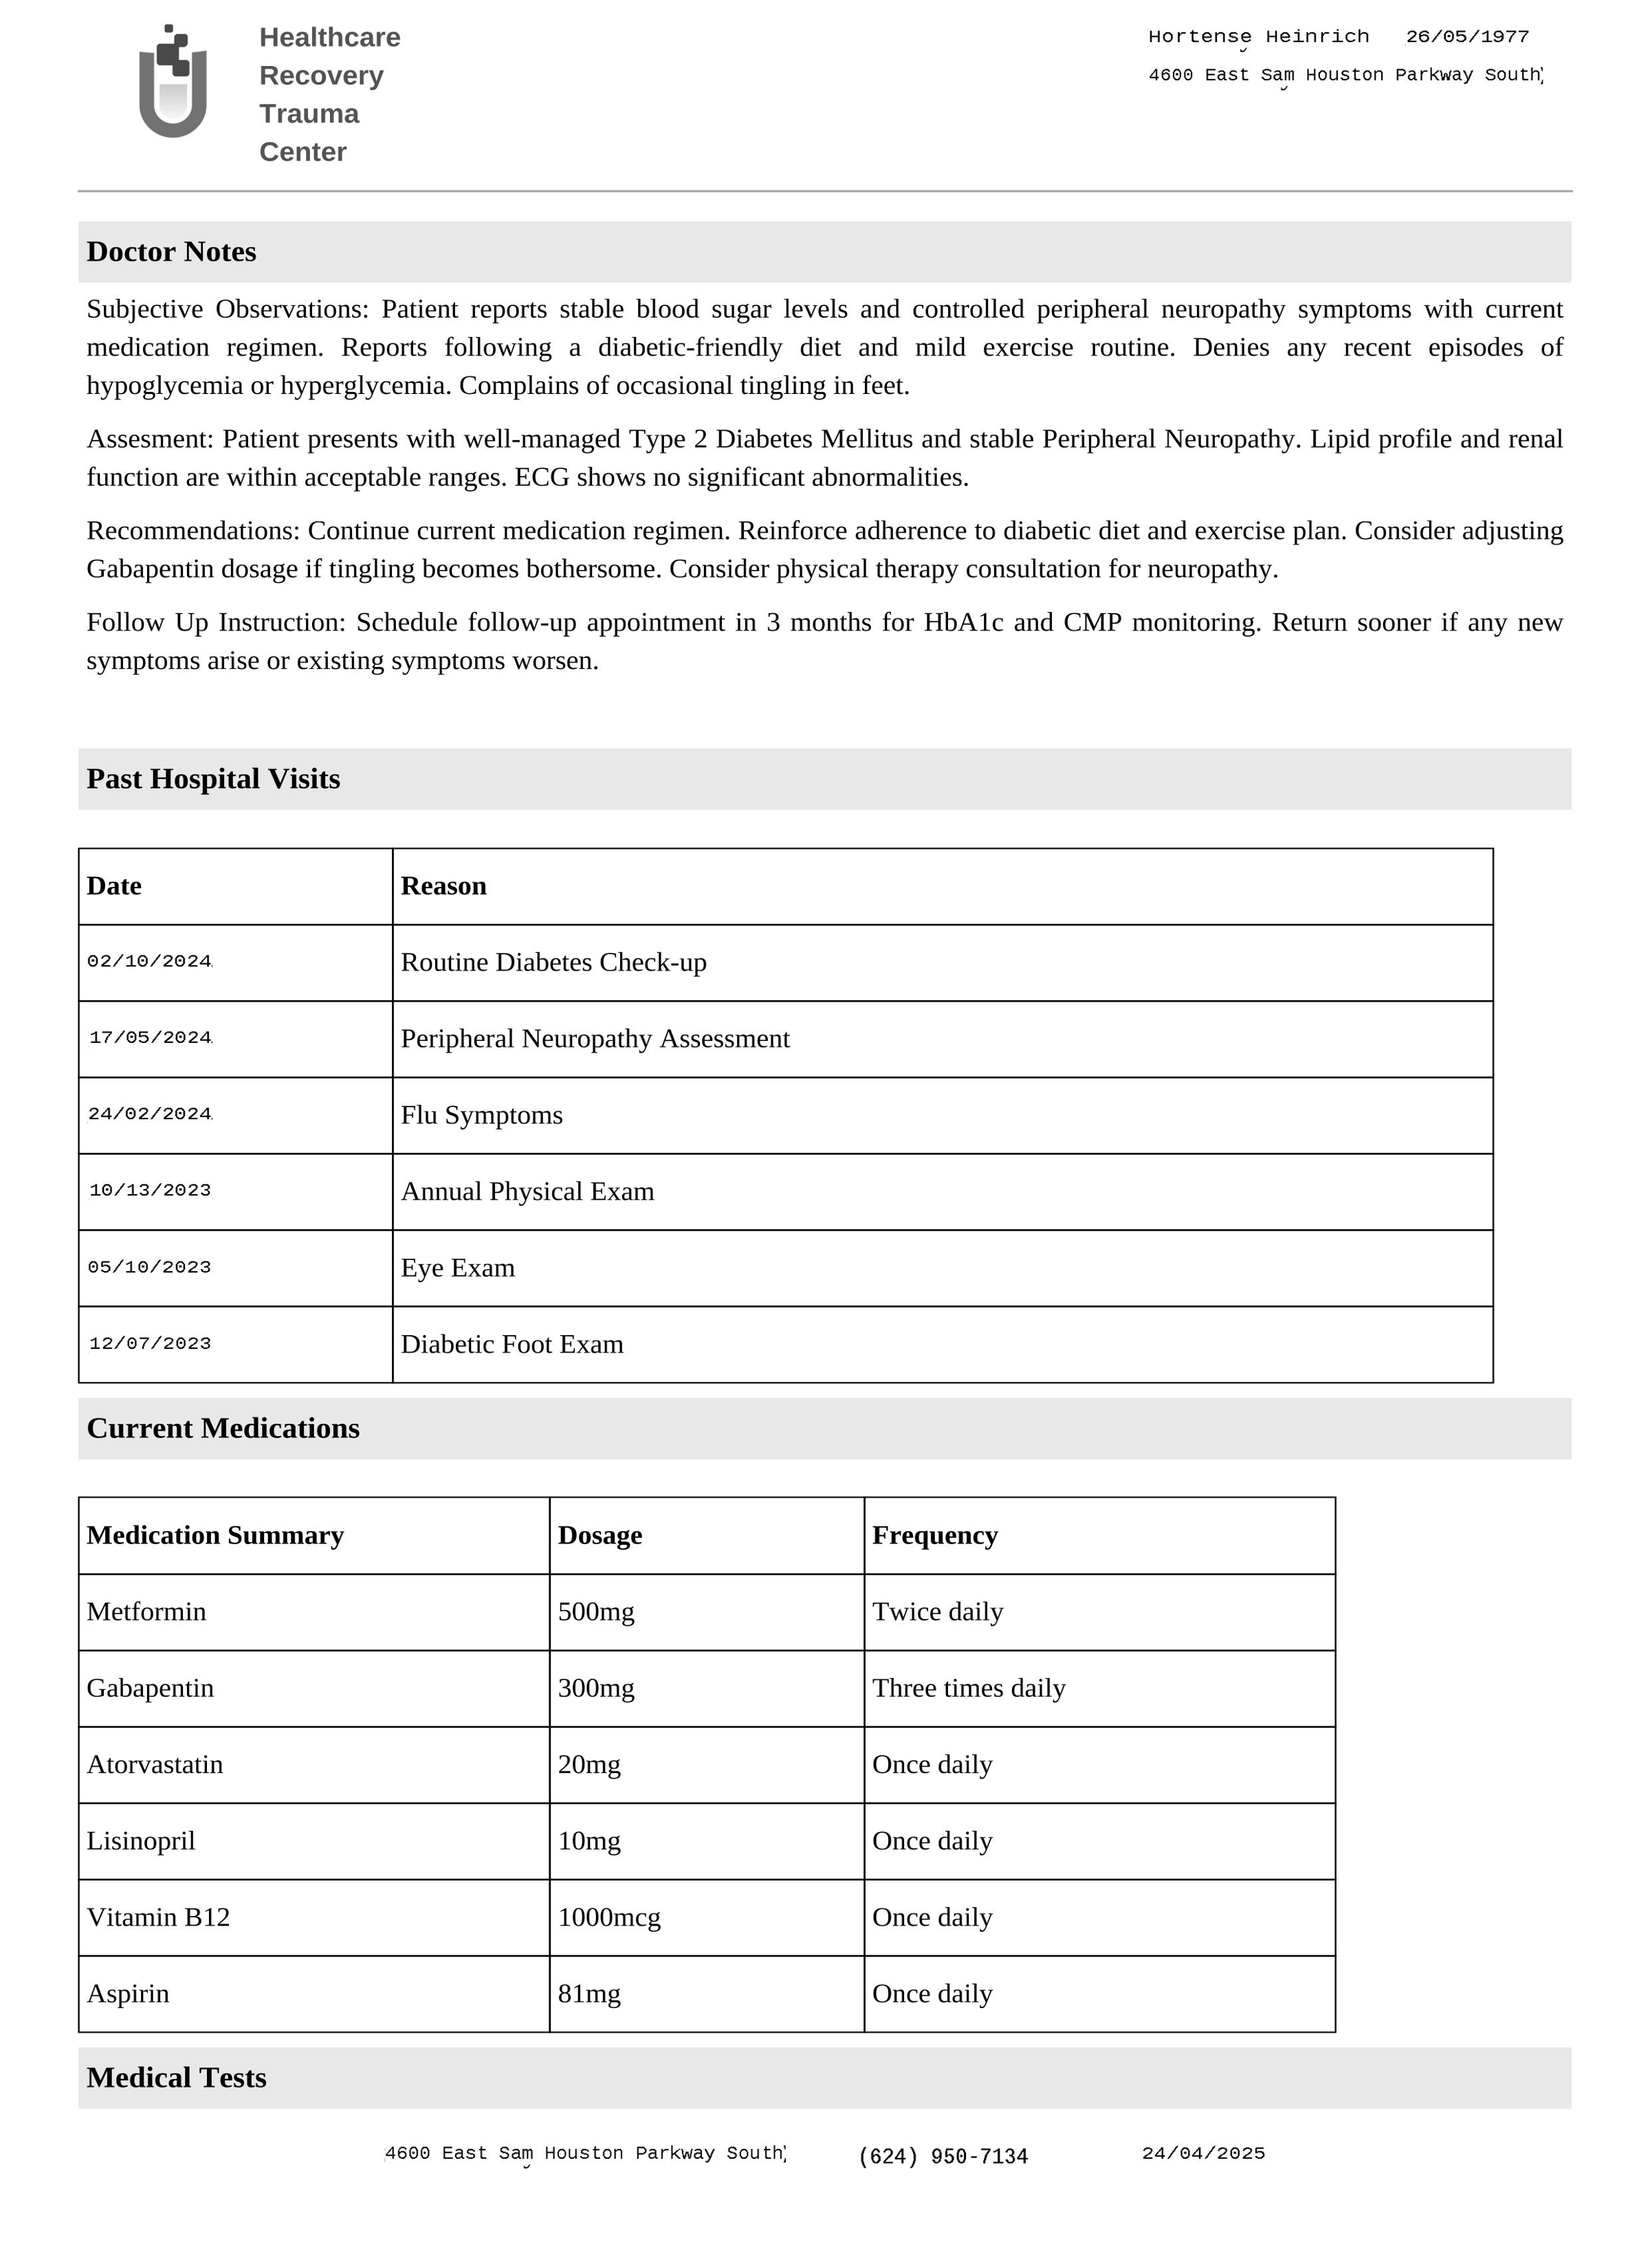


    Image #1:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


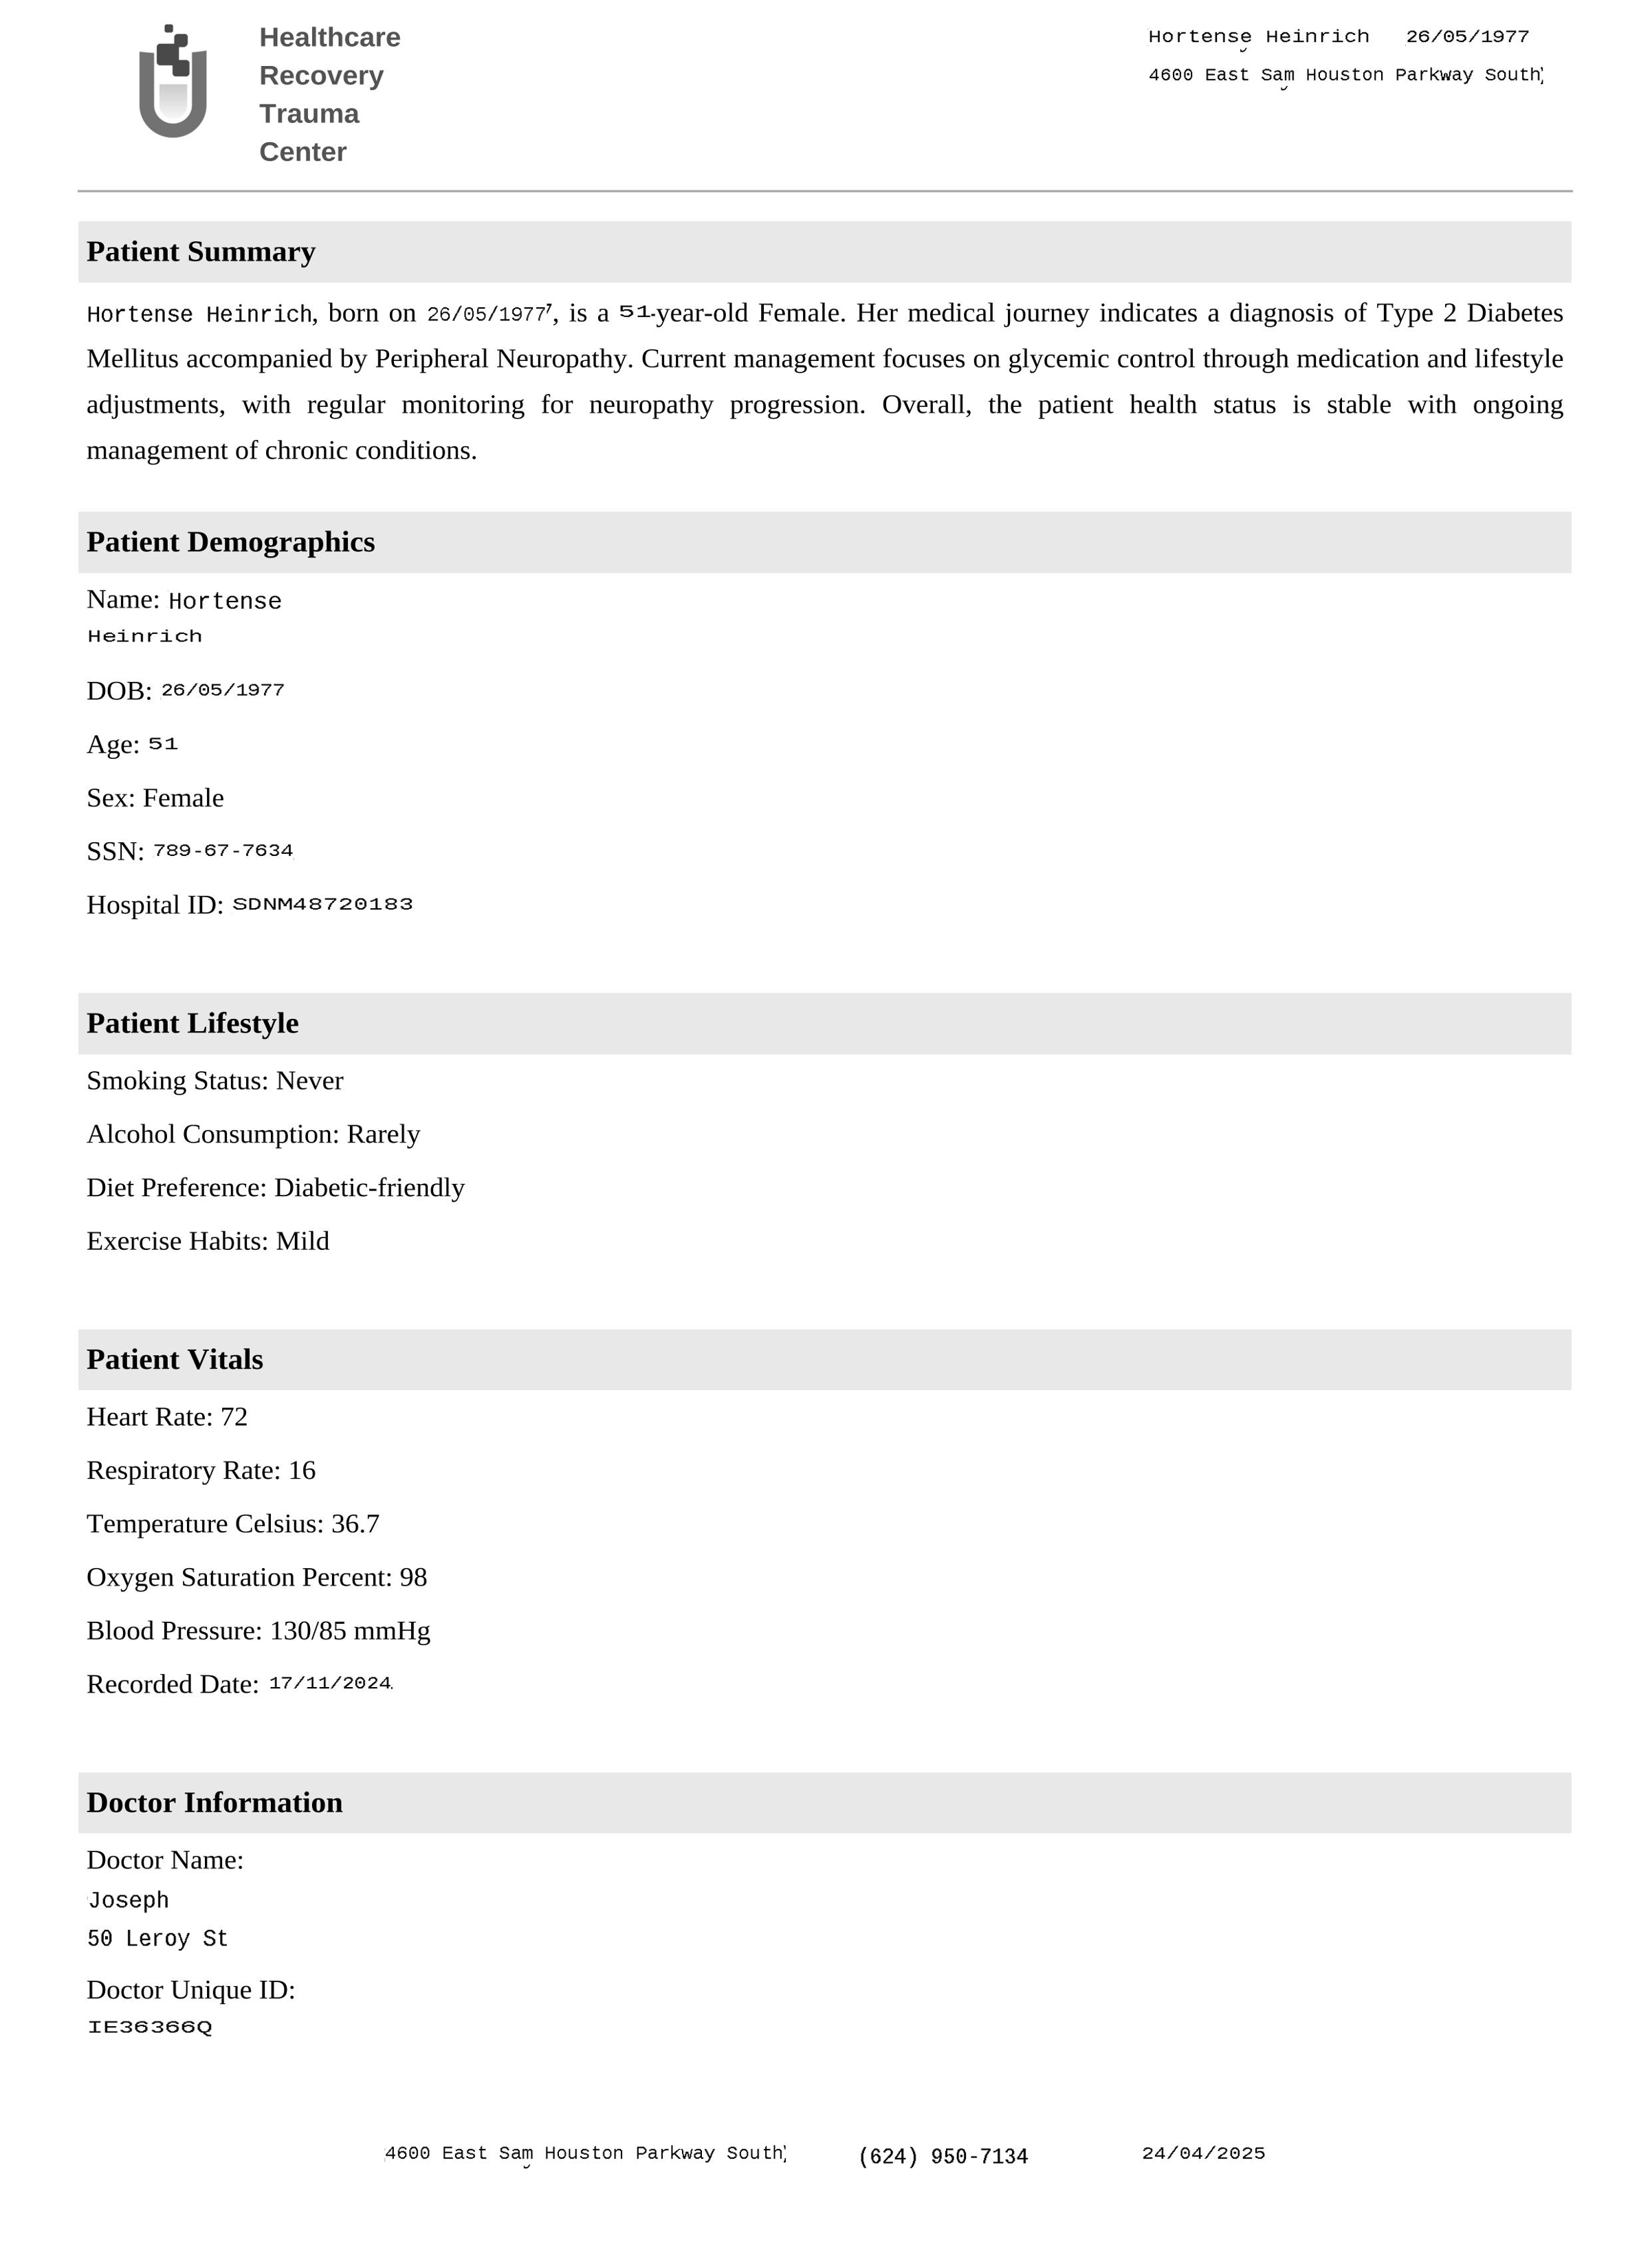


    Image #2:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


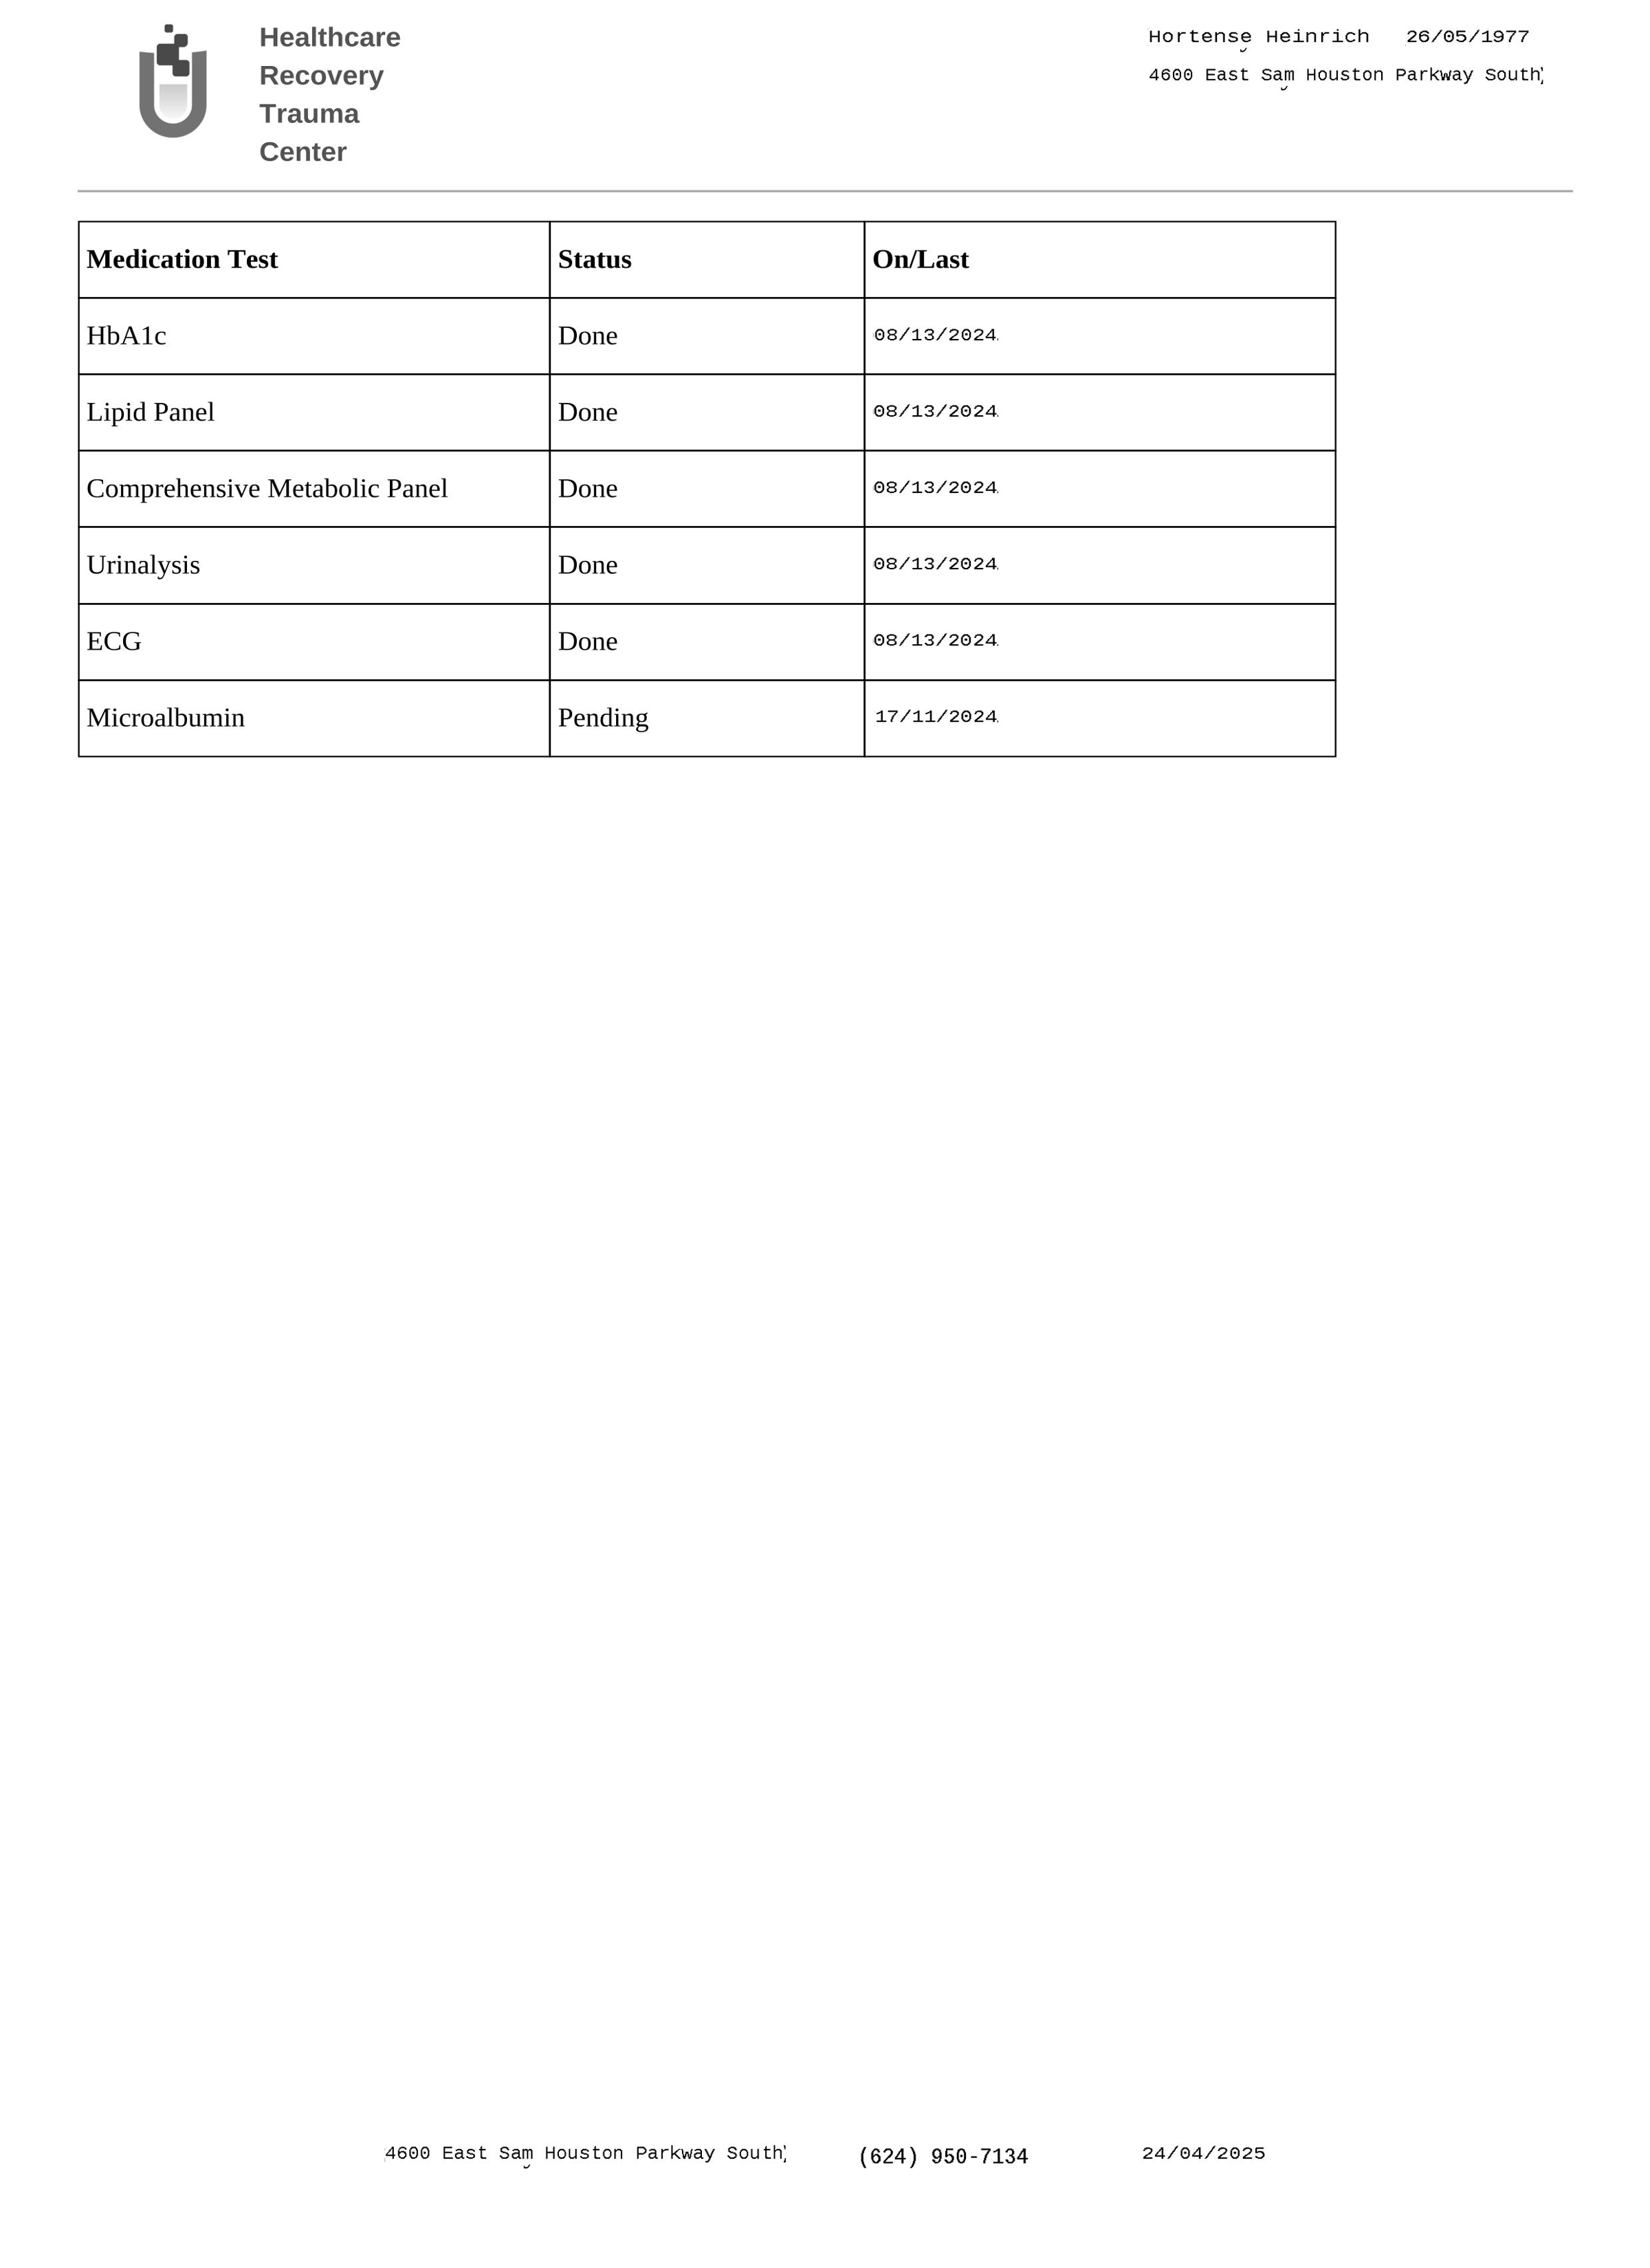

In [17]:
display_pdf(result_df, "pdf")

In [18]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="obfuscate",
       ocr="v1",
       use_gpu=False,
       keep_memory=True,
       pdf_finalizer=False
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [19]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path',
 'modificationTime',
 'length',
 'total_pages',
 'image_raw',
 'pagenum',
 'documentnum',
 'confidence',
 'text',
 'positions',
 'document',
 'sentence',
 'token',
 'embeddings',
 'ner',
 'ner_chunk_large',
 'ner_enriched',
 'ner_chunk_enriched',
 'deid_merged_chunk',
 'entity_ssn',
 'entity_account',
 'entity_dln',
 'entity_plate',
 'entity_vin',
 'entity_license',
 'entity_country',
 'entity_state',
 'entity_age',
 'entity_date',
 'entity_phone',
 'entity_zip',
 'entity_med',
 'entity_email',
 'deid_merged_parse1',
 'ner_chunk',
 'obfuscated',
 'aux',
 'new_aux',
 'positions_ner',
 'coordinates',
 'image_with_regions',
 'exception']

In [21]:
# View the final results
# ObfuscatedResult - Output from DeIdentification Stage
# ObfuscatedLength - Length of Obfuscated Text
# DetectedPhi - Original Text detected as PHI by NER Stages
# OriginalLength - Length of Original Text
# LengthOffSet - Absolute difference between ObfuscatedText length and Detected Phi Text Length
# EntityClass - Entity type detected by NER stages

result_df.withColumn("res", F.explode(F.col("new_aux"))) \
    .select(F.col("res.result").alias("ObfuscatedResult"),
            F.length("res.result").alias("ObfuscatedLength"),
            F.col("res.metadata.originalChunk").alias("DetectedPhi"),
            F.length("res.metadata.originalChunk").alias("OriginalLength"),
            F.abs(F.col("ObfuscatedLength") - F.col("OriginalLength")).alias("LengthOffset"),
            F.col("res.metadata.entity").alias("EntityClass"),
            F.col("pagenum")) \
    .orderBy("pagenum").show(100, False)

+-----------------------------------+----------------+-----------------------------------+--------------+------------+-----------+-------+
|ObfuscatedResult                   |ObfuscatedLength|DetectedPhi                        |OriginalLength|LengthOffset|EntityClass|pagenum|
+-----------------------------------+----------------+-----------------------------------+--------------+------------+-----------+-------+
|26/05/1977                         |10              |24/05/1977                         |10            |0           |DATE       |0      |
|Hortense Heinrich                  |17              |Kimberly Lawrence                  |17            |0           |PATIENT    |0      |
|4600 East Sam Houston Parkway South|35              |Sierra Valley Medical Institute INC|35            |0           |LOCATION   |0      |
|Hortense Heinrich                  |17              |Kimberly Lawrence                  |17            |0           |PATIENT    |0      |
|26/05/1977                

In [27]:
# Use PdfToImage to extract Images from PDF.
pdf_to_image = PdfToImage() \
  .setInputCol("content") \
  .setSplitNumBatch(10) \
  .setResolution(400) \
  .setOutputCol("image_raw") \
  .setImageType(ImageType.TYPE_3BYTE_BGR) \
  .setSplittingStategy(SplittingStrategy.FIXED_NUMBER_OF_PARTITIONS)

# Call PDF To Image
images = pdf_to_image.transform(input_df)

# Extract the first page and convert to image, can be repurposed to save image to disk.
image_dict = images.filter(F.col("pagenum") == 0).select("image_raw").collect()[0].asDict()["image_raw"]
mode = image_dict["mode"]
image = to_pil_image(image_dict, mode)

# Save to Temporary Location
import tempfile

with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
    image.save(tmp_file.name, format="PNG")
    print(f"Image saved at: {tmp_file.name}")

Image saved at: /tmp/tmp1oy0yx16.png


In [28]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="image",
       task="deid",
       ocr="v1",
       use_gpu=False,
       keep_memory=True)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [29]:
pipeline_model = builder.build()
input_df = spark.read.format("binaryFile").load(tmp_file.name)
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['image_raw',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'confidence',
 'text',
 'positions',
 'document',
 'sentence',
 'token',
 'embeddings',
 'ner',
 'ner_chunk_large',
 'ner_enriched',
 'ner_chunk_enriched',
 'deid_merged_chunk',
 'entity_ssn',
 'entity_account',
 'entity_dln',
 'entity_plate',
 'entity_vin',
 'entity_license',
 'entity_country',
 'entity_state',
 'entity_age',
 'entity_date',
 'entity_phone',
 'entity_zip',
 'entity_med',
 'entity_email',
 'deid_merged_parse1',
 'ner_chunk',
 'obfuscated',
 'aux',
 'new_aux',
 'positions_ner',
 'coordinates',
 'image_with_regions',
 'exception']

In [30]:
# View the final results
# ObfuscatedResult - Output from DeIdentification Stage
# ObfuscatedLength - Length of Obfuscated Text
# DetectedPhi - Original Text detected as PHI by NER Stages
# OriginalLength - Length of Original Text
# LengthOffSet - Absolute difference between ObfuscatedText length and Detected Phi Text Length
# EntityClass - Entity type detected by NER stages

result_df.withColumn("res", F.explode(F.col("new_aux"))) \
    .select(F.col("res.result").alias("ObfuscatedResult"),
            F.length("res.result").alias("ObfuscatedLength"),
            F.col("res.metadata.originalChunk").alias("DetectedPhi"),
            F.length("res.metadata.originalChunk").alias("OriginalLength"),
            F.abs(F.col("ObfuscatedLength") - F.col("OriginalLength")).alias("LengthOffset"),
            F.col("res.metadata.entity").alias("EntityClass"),
            F.col("pagenum")) \
    .orderBy("pagenum").show(100, False)

+-----------------------------------+----------------+-----------------------------------+--------------+------------+-----------+-------+
|ObfuscatedResult                   |ObfuscatedLength|DetectedPhi                        |OriginalLength|LengthOffset|EntityClass|pagenum|
+-----------------------------------+----------------+-----------------------------------+--------------+------------+-----------+-------+
|Hortense Heinrich                  |17              |Kimberly Lawrence                  |17            |0           |PATIENT    |0      |
|26/05/1977                         |10              |24/05/1977                         |10            |0           |DATE       |0      |
|4600 East Sam Houston Parkway South|35              |Sierra Valley Medical Institute INC|35            |0           |LOCATION   |0      |
|Hortense Heinrich                  |17              |Kimberly Lawrence                  |17            |0           |PATIENT    |0      |
|26/05/1977                

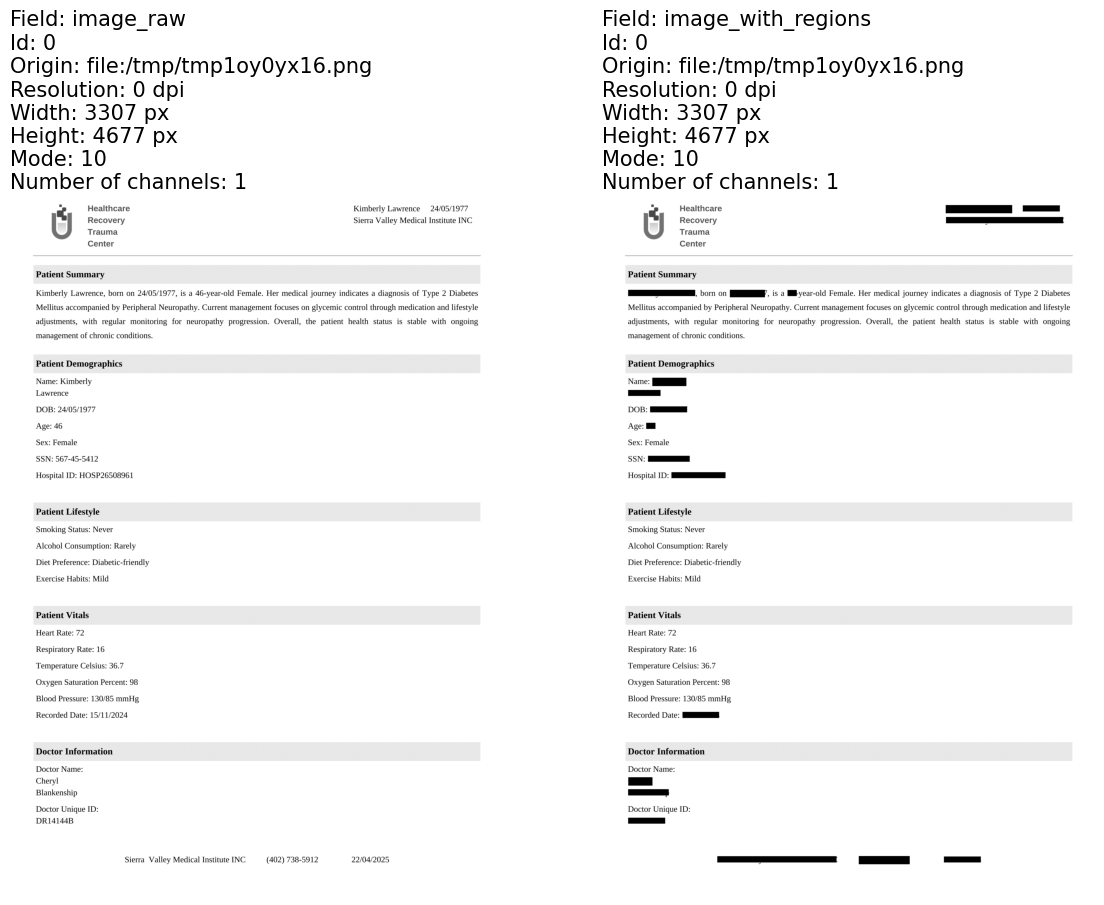

In [31]:
display_images_horizontal(result_df, "image_raw,image_with_regions")

In [32]:
tmp_file.close()

## 🔍 OCR Stage Variants  

We support multiple versions of OCR stages depending on accuracy and implementation details:  

- **`v1`** → `ImageToText`  
- **`v2`** → `ImageTextDetector (Scala)` + `ImageToTextV2 (Scala)`  
- **`v3`** → `ImageTextDetector (Scala)` + `ImageToTextV3`  

In [33]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="deid",
       ocr="v2",
       use_gpu=False,
       keep_memory=True
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [35]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")

In [37]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="deid",
       ocr="v3",
       use_gpu=False,
       keep_memory=True
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [38]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")

### 🧠 Keep Memory  

- **Scope**: Works at the **file level** (not just per page).  
- **Purpose**: Ensures **consistent deidentification/obfuscation** across all pages in a document.  

---

#### Why it matters  
- Sometimes, **PHI may be detected on some pages but missed on others**.  
- Example: A name like *Kimberly Lawrence* might be caught on **Page 1** and **Page 3**, but missed on **Page 2**.  
- With **Keep Memory**, the pipeline uses detections from other pages (plus regex rules) to fill in the missing detections, ensuring **cross-page consistency**.  

---

### ⚙️ User Controls  

Users can customize how regex-based matching is applied:  

1. **Matcher Dictionary (`matcher_dict`)**  
   - Define thresholds per entity class.  
   - Example:  
     ```json
     {"NAME": 0.6, "AGE": 0.8, "PHONE": 0.9}
     ```  
   - Each entity type is accepted only if its **confidence score** meets the defined threshold.  

2. **Static Threshold (`default_matcher_threshold`)**  
   - Apply the same threshold to **all entity classes**.  
   - Example with `default_matcher_threshold=0.5`:  
     ```json
     {"NAME": 0.5, "AGE": 0.5, "PHONE": 0.5}
     ```  

---

### ⚠️ Important Note  

- The **entity class must be supported by the HC pretrained pipeline**.  
- If a class is not handled (e.g., `"ADDRESS"`) and is passed in `matcher_dict` it will be ignored.  
  ```json
  {"ADDRESS": 0.6}
  ```

In [41]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="deid",
       ocr="v1",
       use_gpu=False,
       keep_memory=True,
       matcher_dict = {"NAME": 0.6, "AGE": 0.8, "PHONE": 0.9}
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [42]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")

In [44]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="deid",
       ocr="v1",
       use_gpu=False,
       keep_memory=True,
       default_matcher_threshold=0.7
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [45]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']


    Image #0:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


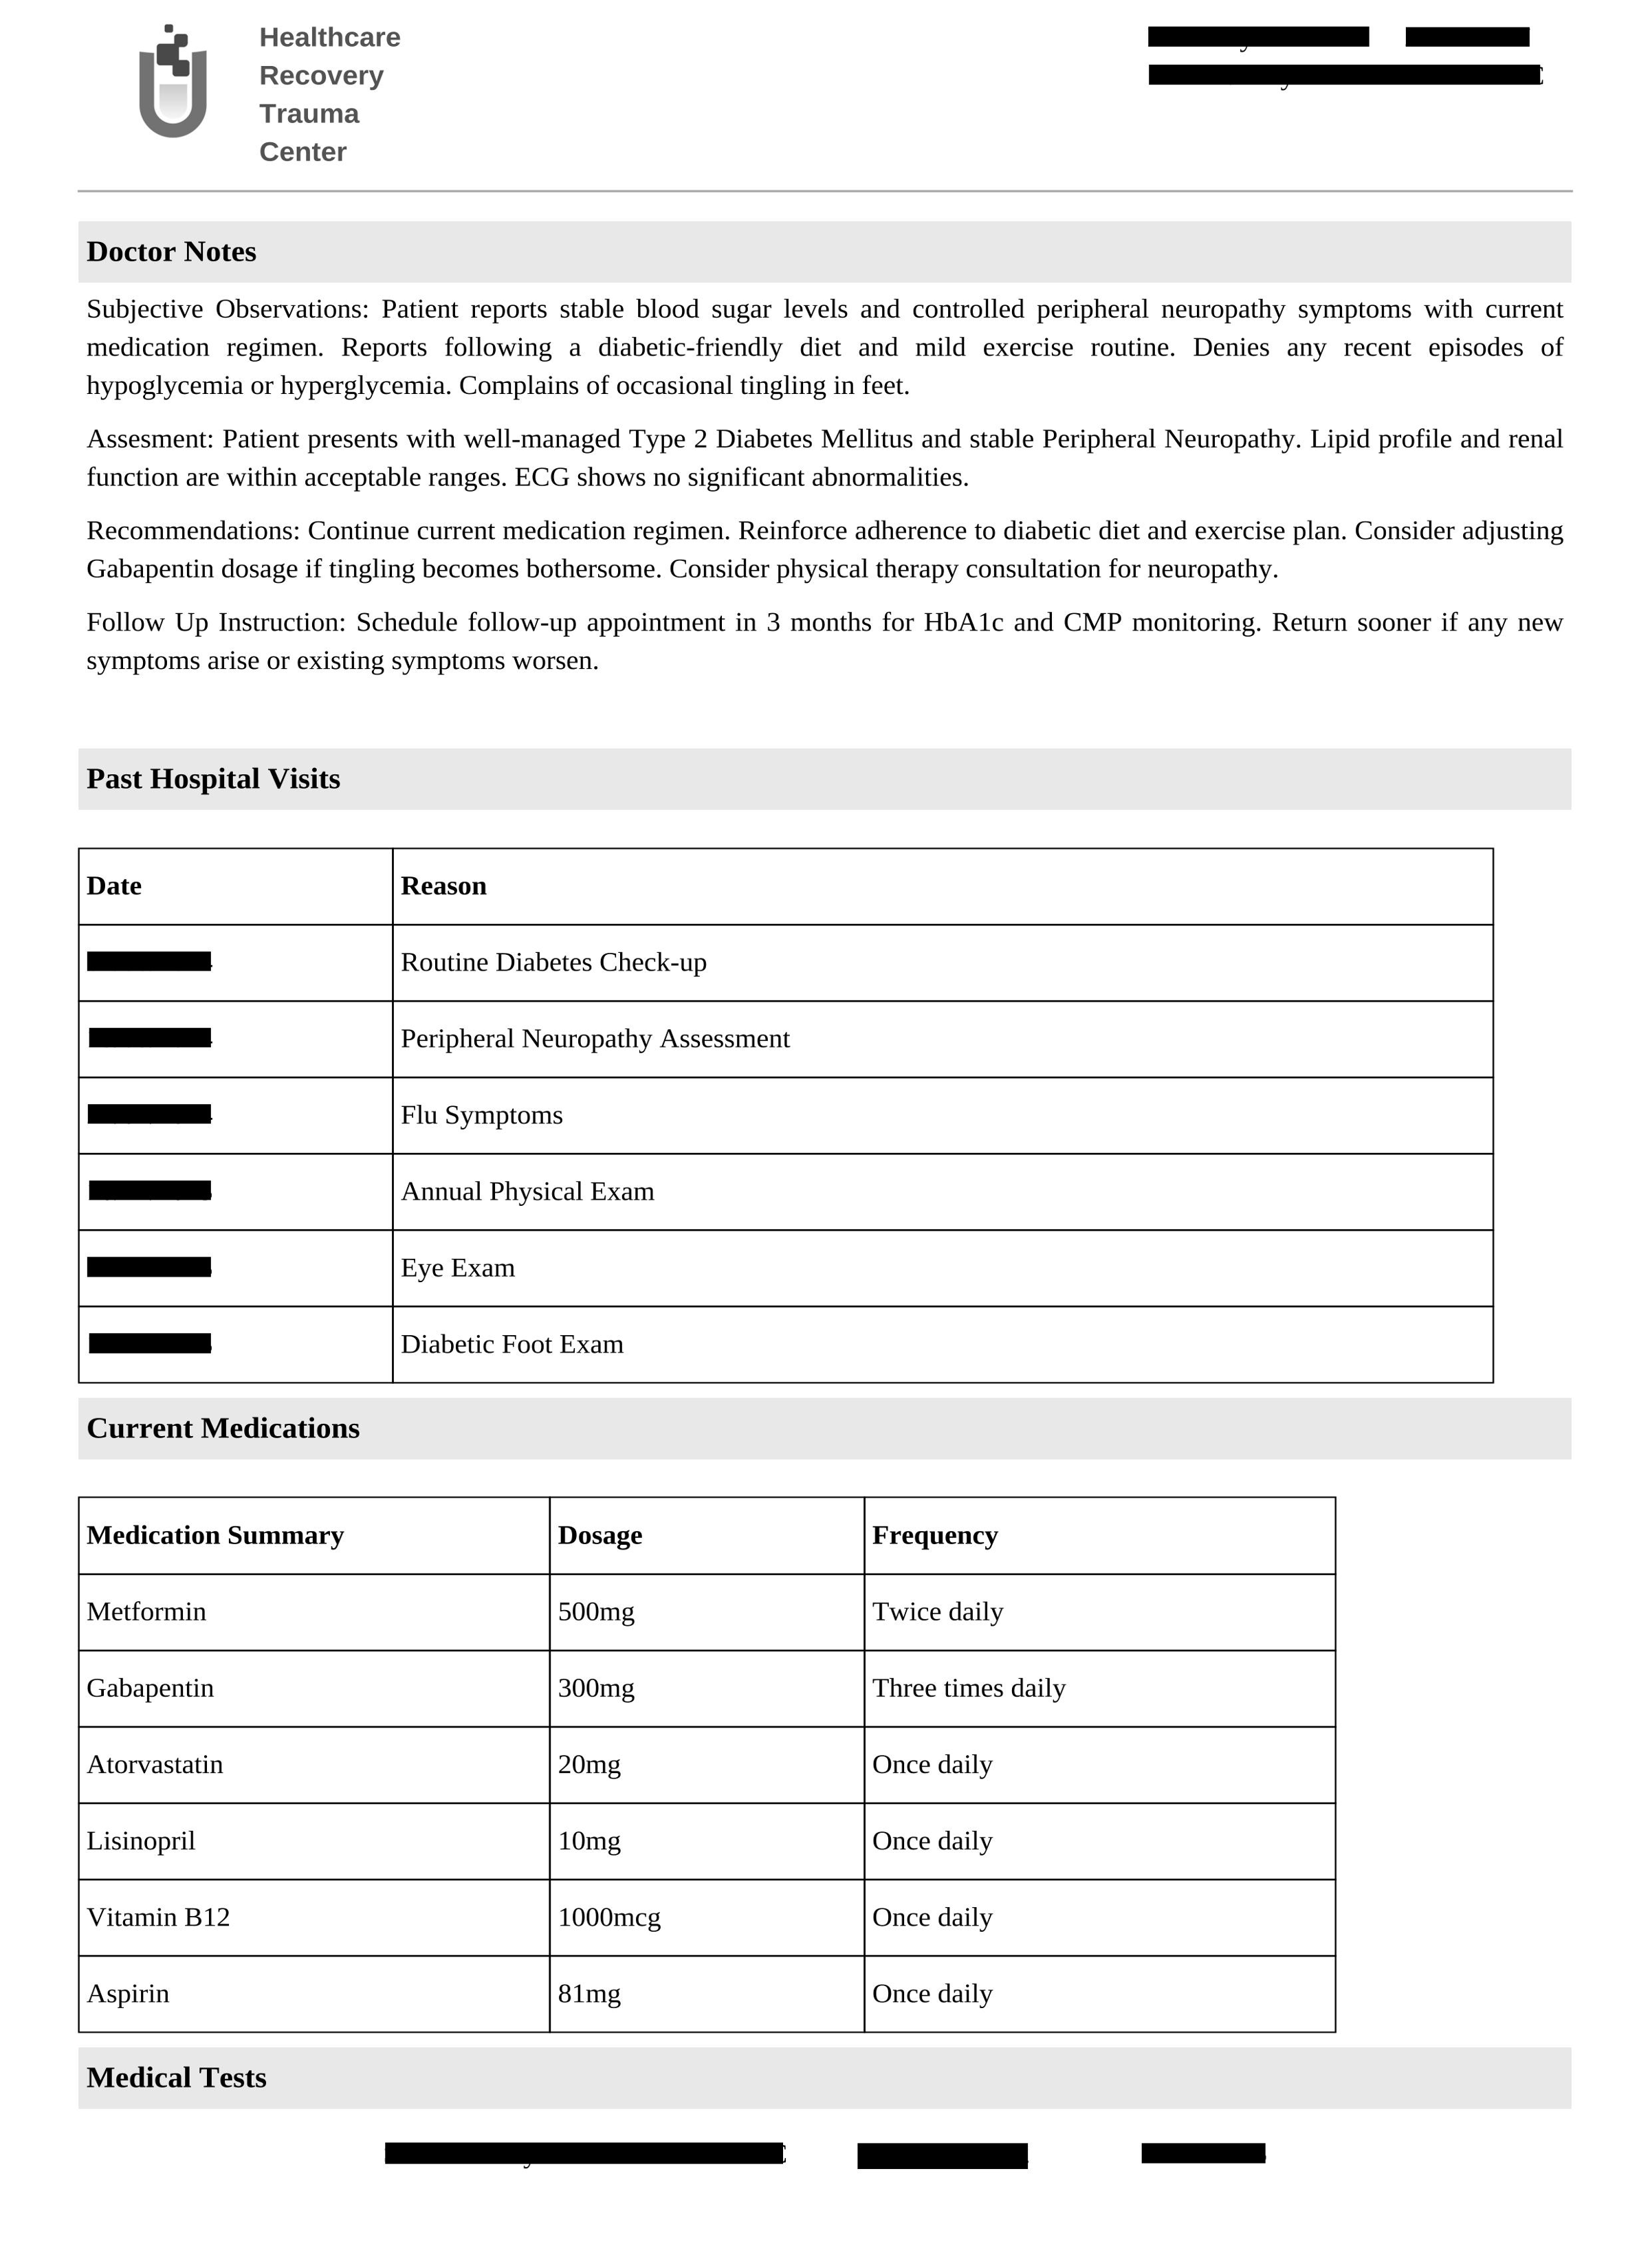


    Image #1:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


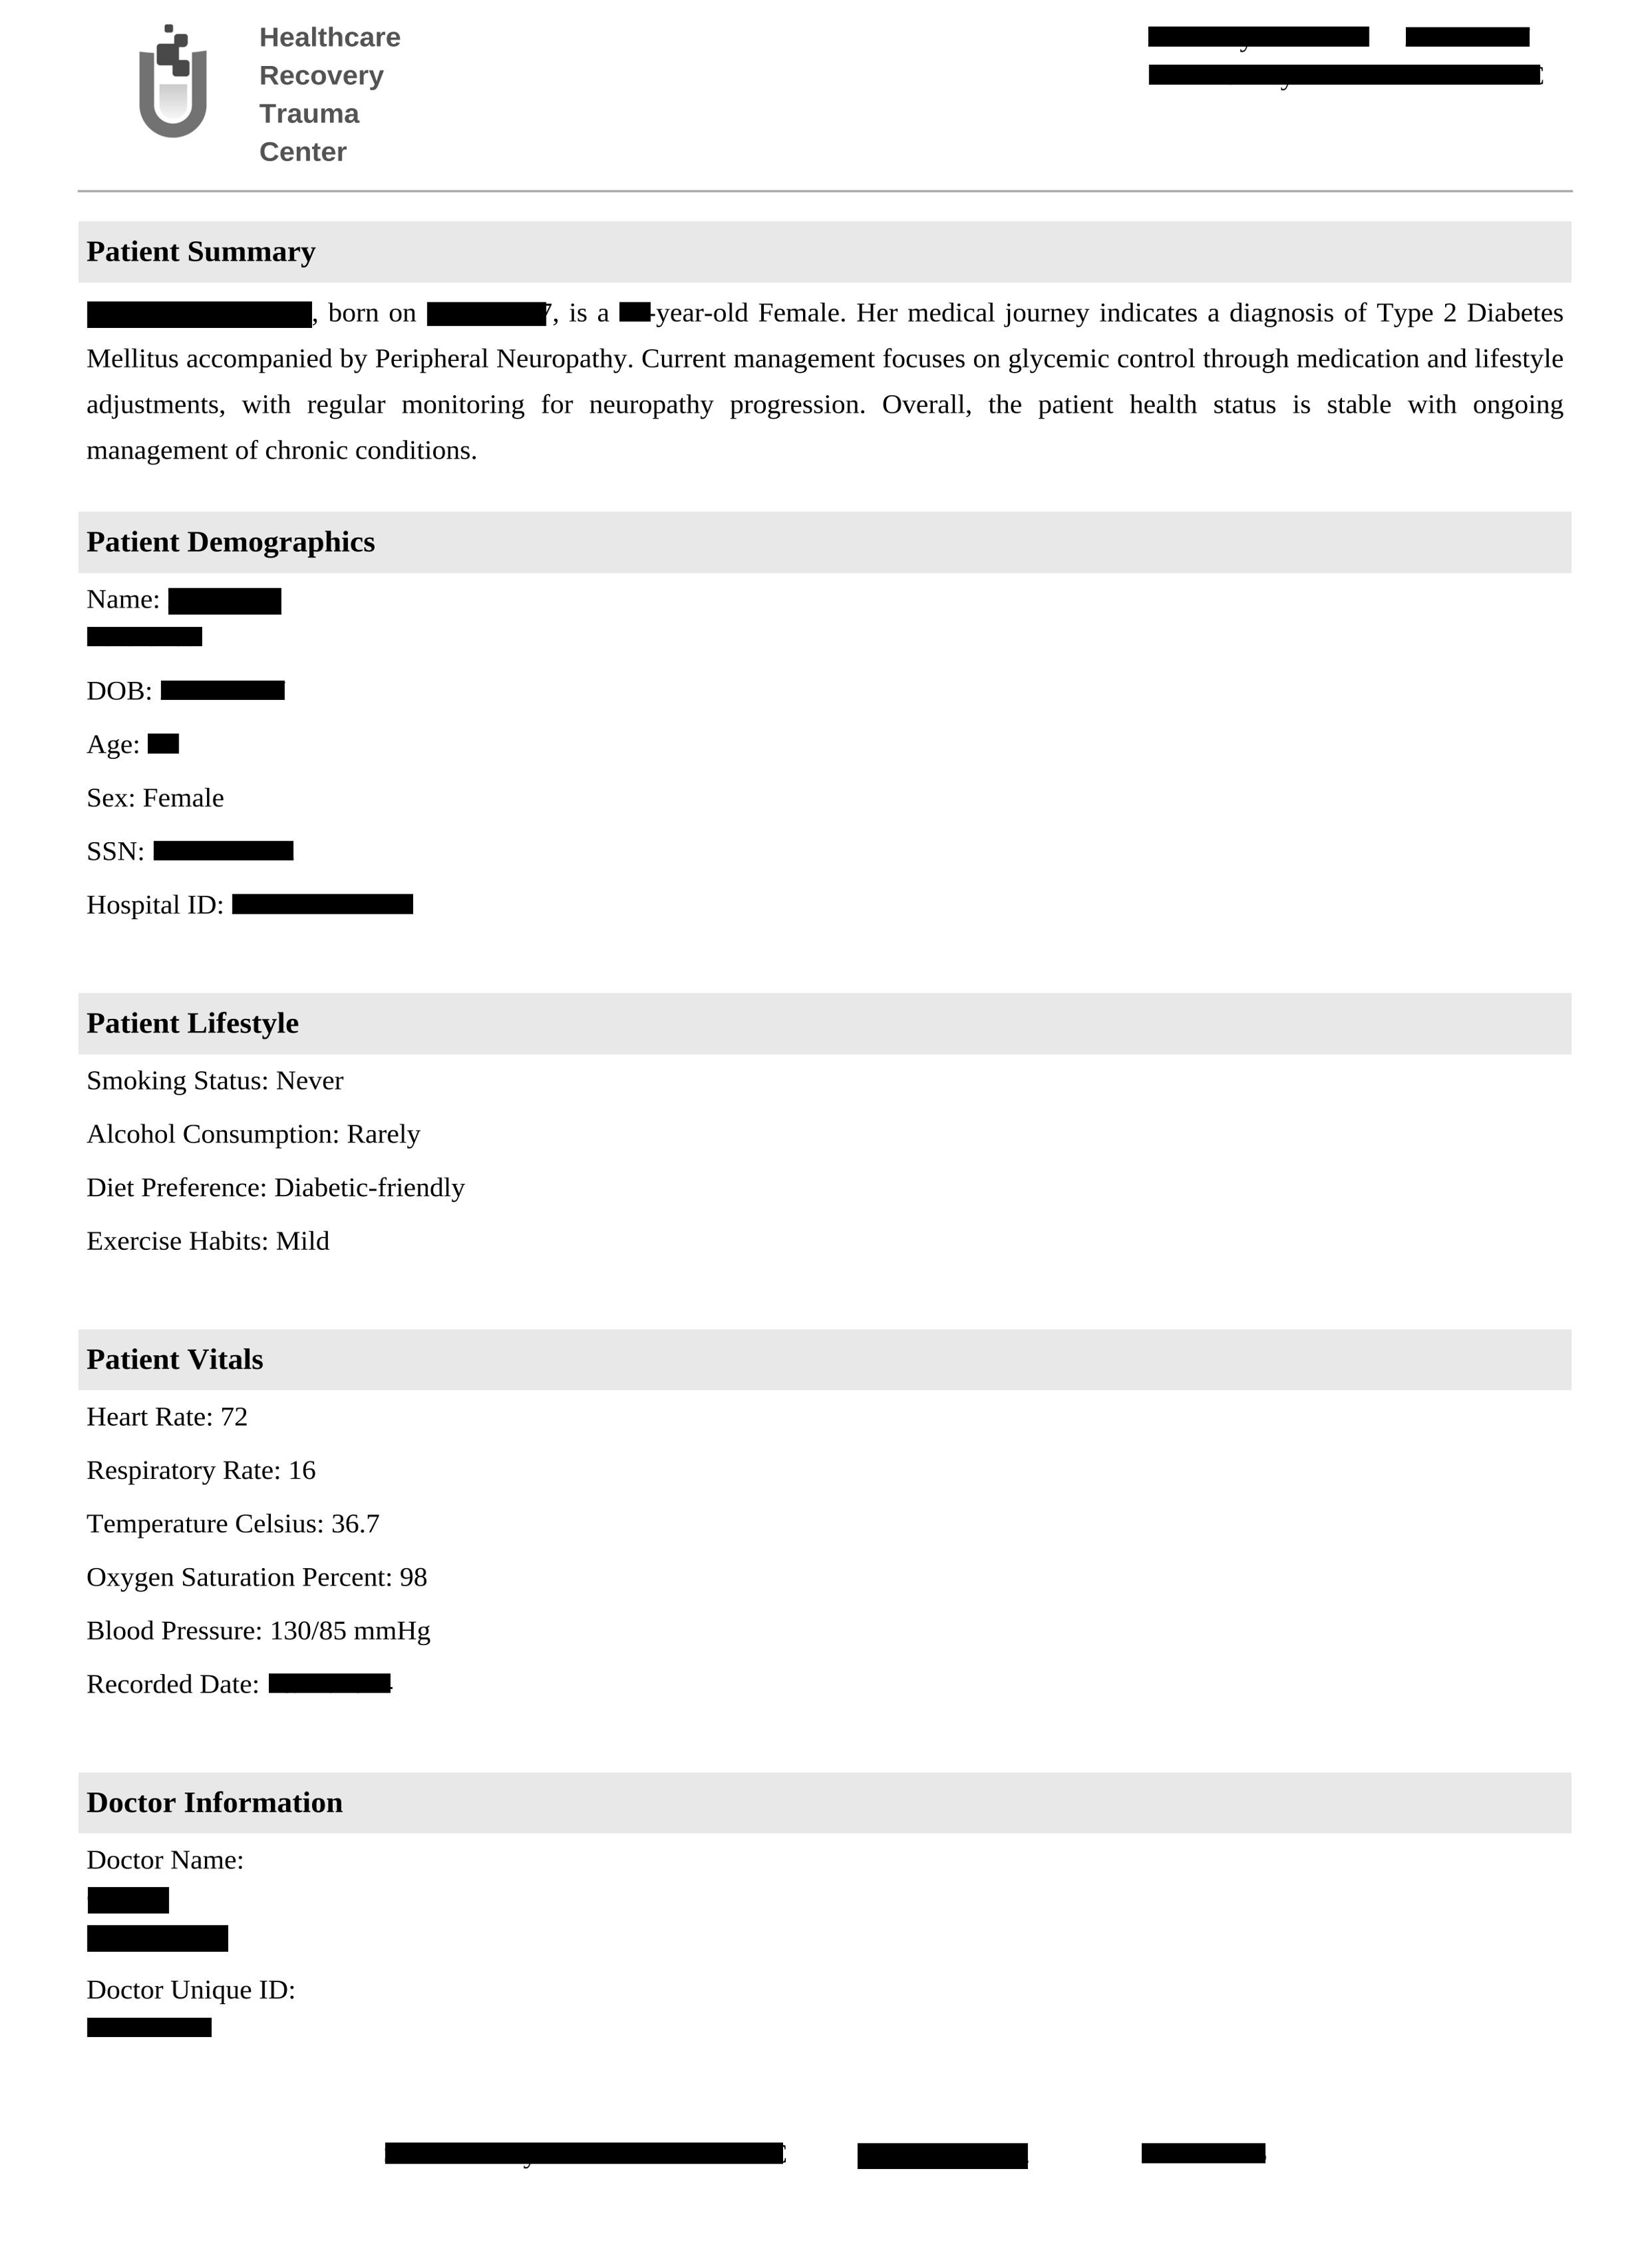


    Image #2:
    Origin: file:/content/PDF_Deid_Deidentification_0.pdf
    Resolution: 300 dpi
    Width: 2400 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


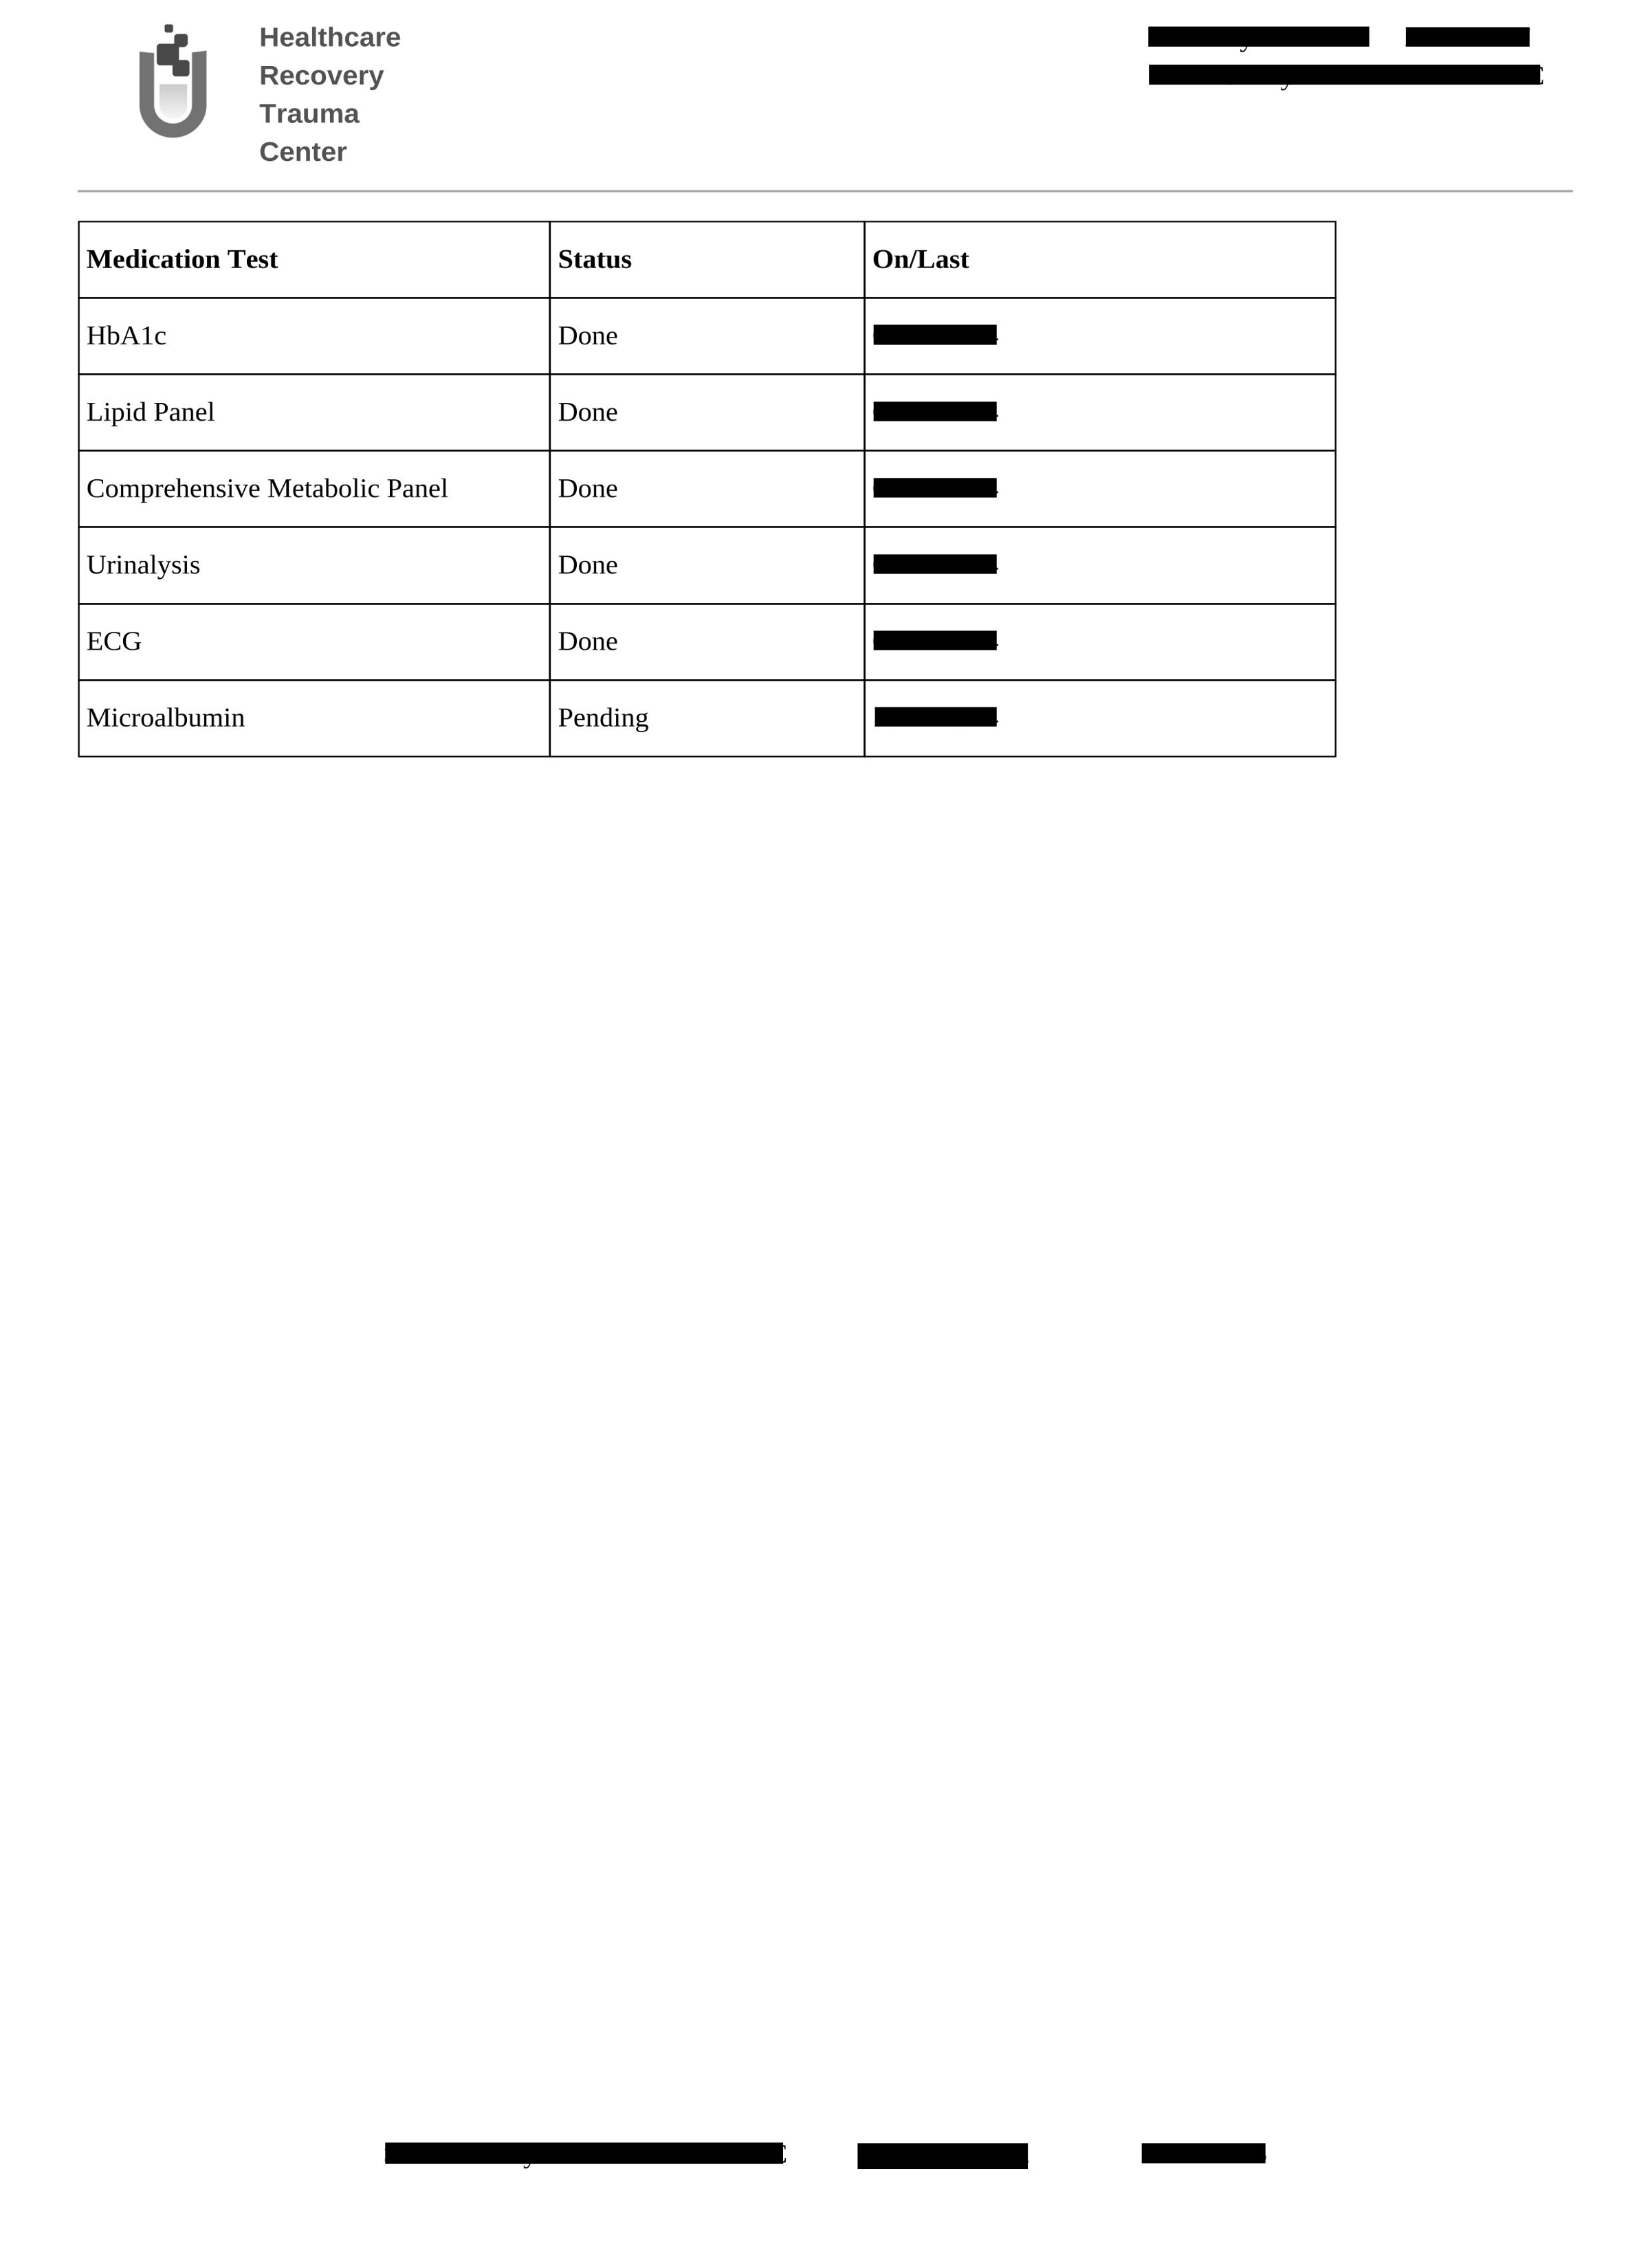

In [46]:
display_pdf(result_df, "pdf")

### ⚙️ Configurable Parameters in Visual NLP & Healthcare Pipelines

There are many components that can be **tweaked** on the Visual NLP and Healthcare side. To make pipelines adaptable to different requirements, we expose the most commonly tuned parameters. Users can access the current configuration using `builder.get_config()`, modify it, and then update with `builder.update_config(config)` **before building the pipeline**. If needed, the configuration can be reset using `builder.reset_config()`.  

```python
# Access current config
config = builder.get_config()

# Update parameters
config["param_name"] = "new_value"
builder.update_config(config)

# Reset to defaults
builder.reset_config()```

In [19]:
builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification",
       input_type="pdf",
       task="obfuscate",
       ocr="v1",
       use_gpu=False,
       keep_memory=True,
       default_matcher_threshold=0.7
)

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [20]:
config = builder.get_config()
config.keys()

dict_keys(['pdfToImage', 'binaryToImage', 'imageToText', 'imageTextDetectorCraft', 'imageToTextV2', 'deidentification', 'positionFinder', 'imageDrawRegions'])

In [8]:
config["pdfToImage"].keys()

dict_keys(['resolution', 'splitBatchNum', 'imageType', 'splittingStrategy'])

In [9]:
config["binaryToImage"].keys()

dict_keys(['imageType'])

In [10]:
config["imageToText"].keys()

dict_keys(['ignoreResolution', 'pageIteratorLevel', 'pageSegMode', 'withSpaces', 'keepLayout', 'threshold'])

In [11]:
config["imageTextDetectorCraft"].keys()

dict_keys(['checkpoint', 'scoreThreshold', 'linkThreshold', 'textThreshold', 'sizeThreshold', 'width', 'height', 'refiner'])

In [12]:
config["imageToTextV2"].keys()

dict_keys(['checkpoint', 'groupImages', 'batchSize', 'taskParallelism'])

In [13]:
config["deidentification"].keys()

dict_keys(['keepMonth', 'keepYear', 'obfuscateDate', 'sameEntityThreshold', 'keepTextSizeForObfuscation', 'fakerLengthOffset', 'returnEntityMappings', 'days', 'ignoreRegex', 'region', 'seed', 'consistentObfuscation'])

In [14]:
config["positionFinder"].keys()

dict_keys(['smoothCoordinates'])

In [15]:
config["imageDrawRegions"].keys()

dict_keys(['rectColor', 'fontStyle', 'fontName', 'patchTextColor', 'patchBackgroundColor', 'redactionList', 'blackList', 'dynamicColor'])

In [24]:
# Update PdfToImage resolution to 400 dpi
# Update ImageDrawRegions to ignore PHONE NUMBER entity class
# Update ImageDrawRegions to redact NAMES instead of obfuscating them

config["pdfToImage"]["resolution"] = 400
config["imageDrawRegions"]["blackList"] = ["PHONE"]
config["imageDrawRegions"]["redactionList"] = ["PATIENT"]

builder.update_config(config)

In [25]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")

In [27]:
builder.reset_config()

In [28]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")

# 🏥 Tested Pretrained Healthcare NLP Pipelines

We evaluated our utility with the following **John Snow Labs pretrained de-identification pipelines**:

- [`clinical_deidentification_pt_3_0`](https://nlp.johnsnowlabs.com/2022/06/21/clinical_deidentification_pt_3_0.html) — Portuguese version (Jun 21, 2022).  
- [`clinical_deidentification_glove_augmented_en_3_0`](https://nlp.johnsnowlabs.com/2022/03/22/clinical_deidentification_glove_augmented_en_3_0.html) — English, GloVe-augmented (Mar 22, 2022).  
- [`clinical_deidentification_docwise_benchmark_medium_en`](https://nlp.johnsnowlabs.com/2025/07/31/clinical_deidentification_docwise_benchmark_medium_en.html) — Document-wise, Medium (Jul 31, 2025).  
- [`clinical_deidentification_docwise_benchmark_large_en`](https://nlp.johnsnowlabs.com/2025/07/25/clinical_deidentification_docwise_benchmark_large_en.html) — Document-wise, Large (Jul 25, 2025).  
- [`clinical_deidentification_docwise_benchmark_light_v2_en`](https://nlp.johnsnowlabs.com/2025/06/11/clinical_deidentification_docwise_benchmark_light_v2_en.html) — Document-wise, Lightweight v2 (Jun 11, 2025).  
- [`clinical_deidentification_docwise_benchmark_en`](https://nlp.johnsnowlabs.com/2025/04/10/clinical_deidentification_docwise_benchmark_en.html) — Document-wise benchmark (Apr 10, 2025).  
- [`clinical_deidentification_multi_mode_output_en`](https://nlp.johnsnowlabs.com/2025/01/03/clinical_deidentification_multi_mode_output_en.html) — Multi-mode output (Jan 03, 2025).  
- [`clinical_deidentification_zeroshot_large_en`](https://nlp.johnsnowlabs.com/2024/12/04/clinical_deidentification_zeroshot_large_en.html) — Zero-shot large model (Dec 04, 2024).  
- [`clinical_deidentification_docwise_large_wip_en`](https://nlp.johnsnowlabs.com/2024/12/03/clinical_deidentification_docwise_large_wip_en.html) — Large WIP (Dec 03, 2024).  
- [`clinical_deidentification_docwise_wip_v2_en`](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_wip_v2_en.html) — WIP v2 (Nov 29, 2024).  

---

### 🔎 Exploring Other Pipelines

Chances are this utility will work with **any de-identification pipeline available in the [John Snow Labs Models Hub](https://nlp.johnsnowlabs.com/models)**.

1. Go to 👉 [https://nlp.johnsnowlabs.com/models](https://nlp.johnsnowlabs.com/models)  
2. In filters:  
   - **Show:** `De-Identification`  
   - **Language:** `EN` (or any available language)  
   - **For:** `All Healthcare NLP Versions`  
   - On the left-hand side, ensure **Pipelines** is selected.  
3. Select the model you want to test. You will see something like:

```python
PretrainedPipeline("clinical_deidentification", "en", "clinical/models")
```

- The **first argument** → pipeline name → `hc_pipeline`  
- The **second argument** → language → `language` (default `"en"`)  
- The **third argument** → remote location → `remote_loc` (default `"clinical/models"`)  


In [ ]:
input_df = spark.read.format("binaryFile").load("./source_pdfs/Medium/PDF_Deid_Deidentification_Medium_0.pdf")

In [38]:
# Lets try https://nlp.johnsnowlabs.com/2024/12/04/clinical_deidentification_zeroshot_large_en.html

builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification_zeroshot_large",
       language="en",
       remote_loc="clinical/models",
       input_type="pdf",
       task="deid",
       ocr="v1",
       use_gpu=False,
       keep_memory=True,
       default_matcher_threshold=0.5
)

clinical_deidentification_zeroshot_large download started this may take some time.
Approx size to download 1.5 GB
[OK!]


In [39]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")

In [ ]:
input_df = spark.read.format("binaryFile").load("./source_pdfs/Hard/PDF_Deid_Deidentification_Hard_0.pdf")

In [41]:
# Lets try https://nlp.johnsnowlabs.com/2025/01/03/clinical_deidentification_multi_mode_output_en.html

builder = AnonymizationPipelineBuilder(
       hc_pipeline="clinical_deidentification_multi_mode_output",
       language="en",
       remote_loc="clinical/models",
       input_type="pdf",
       task="deid",
       ocr="v1",
       use_gpu=False,
       keep_memory=True,
       default_matcher_threshold=0.5
)

clinical_deidentification_multi_mode_output download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [42]:
pipeline_model = builder.build()
result_df = pipeline_model.fit(input_df).transform(input_df)

result_df.columns

['path', 'images', 'pages', 'pdf', 'exception']

In [ ]:
#display_pdf(result_df, "pdf")